<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel, Ph.D Astrophysics</a> .
</div>

# Description
In this notebook we will explore the explanability of the binary classifier
xgboost classifier.

- [eli5](https://github.com/TeamHG-Memex/eli5/)
- [shap](https://github.com/slundberg/shap)
- [pdp](https://github.com/SauceCat/PDPbox)
- [yellowbrick](https://github.com/DistrictDataLabs/yellowbrick)

# Imports

In [ ]:
import time,os,json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') # random state
SEED=100
home = os.path.expanduser('~')
[(x.__name__,x.__version__) for x in [np,pd,sns]]

[('numpy', '1.18.5'), ('pandas', '1.0.4'), ('seaborn', '0.10.1')]

In [ ]:
%%capture
# capture will not print in notebook

import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## model evaluation
    !pip install -U watermark
    !pip install -U xgboost
    !pip install -U eli5
    !pip install -U shap
    !pip install -U pdpbox
    !pip install -U yellowbrick
    !pip install -U lime

    #### print
    print('Environment: Google Colaboratory.')

# NOTE: If we update modules in gcolab, we need to restart runtime.

In [ ]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [ ]:
%watermark -a "Bhishan Poudel" -d
%watermark -v -m -p numpy,scipy,pandas,seaborn,sklearn,xgboost,eli5,shap,pdpbox,yellowbrick -g

Bhishan Poudel 2020-06-19
CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
scipy 1.4.1
pandas 1.0.4
seaborn 0.10.1
sklearn 0.0
xgboost 0.90
eli5 0.10.1
shap 0.35.0
pdpbox 0.2.0
yellowbrick 0.9.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.104+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


# Load the data

In [ ]:
def get_data():
    df = pd.read_csv('https://github.com/bhishanpdl/Datasets/blob/master/Prudential_Insurance/raw/train.csv.zip?raw=true',compression='zip')
    df = df.copy()
    columns_to_drop = ['Id', 'Medical_History_10','Medical_History_24']
    df = df.drop(columns_to_drop,axis=1)
    df['Product_Info_2_char'] = df.Product_Info_2.str[0]
    df['Product_Info_2_num'] = df.Product_Info_2.str[1]

    # factorize categorical variables
    df['Product_Info_2'] = pd.factorize(df['Product_Info_2'])[0]
    df['Product_Info_2_char'] = pd.factorize(df['Product_Info_2_char'])[0]
    df['Product_Info_2_num'] = pd.factorize(df['Product_Info_2_num'])[0]

    df['BMI_Age'] = df['BMI'] * df['Ins_Age']

    med_keyword_columns = df.columns[df.columns.str.startswith('Medical_Keyword_')]
    df['Med_Keywords_Count'] = df[med_keyword_columns].sum(axis=1)
    df = df.fillna(-1)

    return df

df = get_data()
print(df.shape)
df.isna().sum().sum(), df.sum().sum()

(59381, 129)


(0, 26897356.818315115)

# Train-test Split with Stratify

In [ ]:
from sklearn.model_selection import train_test_split

target = 'Response'

df_Xtrain, df_Xtest, ser_ytrain, ser_ytest = train_test_split(
    df.drop(target,axis=1), df[target],
    test_size=0.2, random_state=SEED, stratify=df[target])

ytrain = ser_ytrain.to_numpy().ravel()
ytest = ser_ytest.to_numpy().ravel()

features_train = df_Xtrain.columns.to_list()
features_train

['Product_Info_1',
 'Product_Info_2',
 'Product_Info_3',
 'Product_Info_4',
 'Product_Info_5',
 'Product_Info_6',
 'Product_Info_7',
 'Ins_Age',
 'Ht',
 'Wt',
 'BMI',
 'Employment_Info_1',
 'Employment_Info_2',
 'Employment_Info_3',
 'Employment_Info_4',
 'Employment_Info_5',
 'Employment_Info_6',
 'InsuredInfo_1',
 'InsuredInfo_2',
 'InsuredInfo_3',
 'InsuredInfo_4',
 'InsuredInfo_5',
 'InsuredInfo_6',
 'InsuredInfo_7',
 'Insurance_History_1',
 'Insurance_History_2',
 'Insurance_History_3',
 'Insurance_History_4',
 'Insurance_History_5',
 'Insurance_History_7',
 'Insurance_History_8',
 'Insurance_History_9',
 'Family_Hist_1',
 'Family_Hist_2',
 'Family_Hist_3',
 'Family_Hist_4',
 'Family_Hist_5',
 'Medical_History_1',
 'Medical_History_2',
 'Medical_History_3',
 'Medical_History_4',
 'Medical_History_5',
 'Medical_History_6',
 'Medical_History_7',
 'Medical_History_8',
 'Medical_History_9',
 'Medical_History_11',
 'Medical_History_12',
 'Medical_History_13',
 'Medical_History_14',
 'Medical_History_15',
 'Medical_History_16',
 'Medical_History_17',
 'Medical_History_18',
 'Medical_History_19',
 'Medical_History_20',
 'Medical_History_21',
 'Medical_History_22',
 'Medical_History_23',
 'Medical_History_25',
 'Medical_History_26',
 'Medical_History_27',
 'Medical_History_28',
 'Medical_History_29',
 'Medical_History_30',
 'Medical_History_31',
 'Medical_History_32',
 'Medical_History_33',
 'Medical_History_34',
 'Medical_History_35',
 'Medical_History_36',
 'Medical_History_37',
 'Medical_History_38',
 'Medical_History_39',
 'Medical_History_40',
 'Medical_History_41',
 'Medical_Keyword_1',
 'Medical_Keyword_2',
 'Medical_Keyword_3',
 'Medical_Keyword_4',
 'Medical_Keyword_5',
 'Medical_Keyword_6',
 'Medical_Keyword_7',
 'Medical_Keyword_8',
 'Medical_Keyword_9',
 'Medical_Keyword_10',
 'Medical_Keyword_11',
 'Medical_Keyword_12',
 'Medical_Keyword_13',
 'Medical_Keyword_14',
 'Medical_Keyword_15',
 'Medical_Keyword_16',
 'Medical_Keyword_17',
 'Medical_Keyword_18',
 'Medical_Keyword_19',
 'Medical_Keyword_20',
 'Medical_Keyword_21',
 'Medical_Keyword_22',
 'Medical_Keyword_23',
 'Medical_Keyword_24',
 'Medical_Keyword_25',
 'Medical_Keyword_26',
 'Medical_Keyword_27',
 'Medical_Keyword_28',
 'Medical_Keyword_29',
 'Medical_Keyword_30',
 'Medical_Keyword_31',
 'Medical_Keyword_32',
 'Medical_Keyword_33',
 'Medical_Keyword_34',
 'Medical_Keyword_35',
 'Medical_Keyword_36',
 'Medical_Keyword_37',
 'Medical_Keyword_38',
 'Medical_Keyword_39',
 'Medical_Keyword_40',
 'Medical_Keyword_41',
 'Medical_Keyword_42',
 'Medical_Keyword_43',
 'Medical_Keyword_44',
 'Medical_Keyword_45',
 'Medical_Keyword_46',
 'Medical_Keyword_47',
 'Medical_Keyword_48',
 'Product_Info_2_char',
 'Product_Info_2_num',
 'BMI_Age',
 'Med_Keywords_Count']

# Modelling xgboost classifier

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb.__version__

'0.90'

In [ ]:
clf_xgb = XGBClassifier(objective= 'multi:softprob', random_state=SEED,n_jobs=-1)
clf_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
%%time
clf_xgb.fit(df_Xtrain, ser_ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=100,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
ypreds = clf_xgb.predict(df_Xtest)

df_ypreds = pd.DataFrame({'ytest': ytest, 'ypreds': ypreds})
df_ypreds['is_Response8'] = df_ypreds['ytest'].eq(8).astype(int)
df_ypreds.head(10)

ytest  ypreds  is_Response8
0      1       6             0
1      7       8             0
2      8       8             1
3      6       6             0
4      7       7             0
5      8       6             1
6      6       6             0
7      8       8             1
8      6       6             0
9      4       4             0

# Feature Importances

In [ ]:
# xgb.plot_importance?

# importance_type = 'weight', 'gain', 'cover'

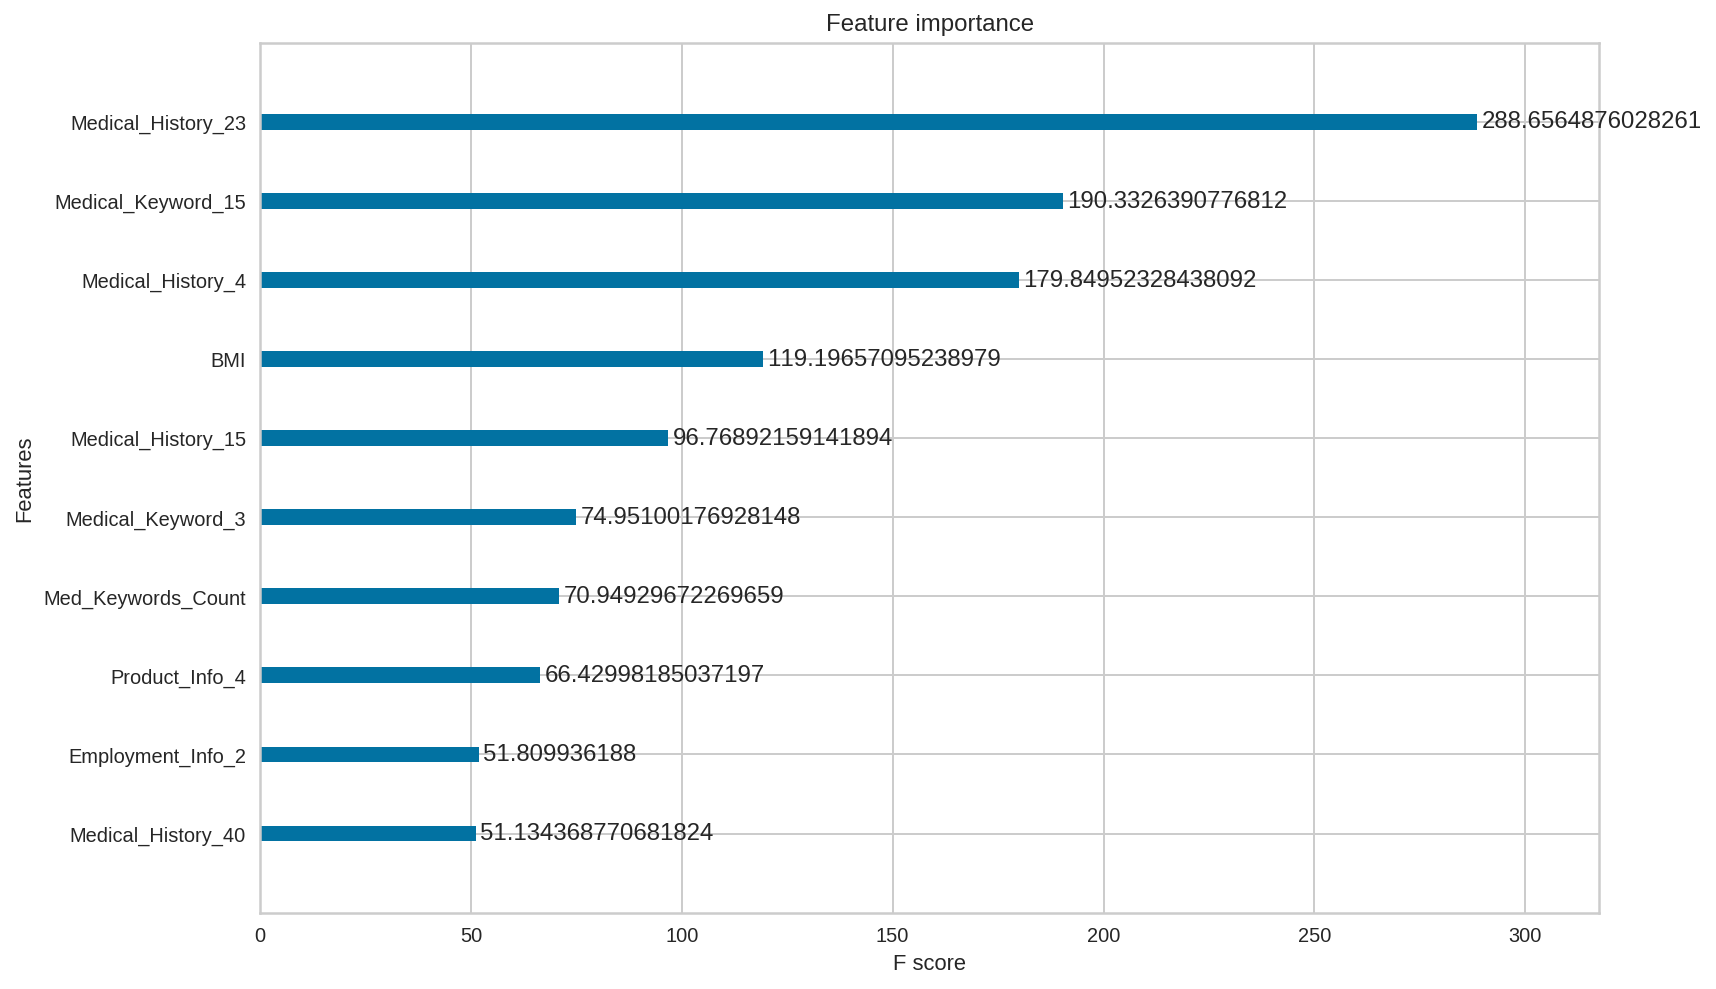

In [ ]:
# feature importance
fig,ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(clf_xgb,ax=ax,max_num_features=10,importance_type='gain')
plt.show()

In [ ]:
df_imp = pd.DataFrame({'feature': features_train,
                      'importance': clf_xgb.feature_importances_})

df_imp.sort_values('importance', ascending=False)\
  .head(10).style.background_gradient(subset=['importance'])

In [ ]:
df_imp.sort_values('importance', ascending=False)\
  .head(10).style.bar(subset=['importance'],align='mid',color='pink')

In [ ]:
from yellowbrick.model_selection import FeatureImportances

In [ ]:
# FeatureImportances?

In [ ]:
# plt.colormaps()

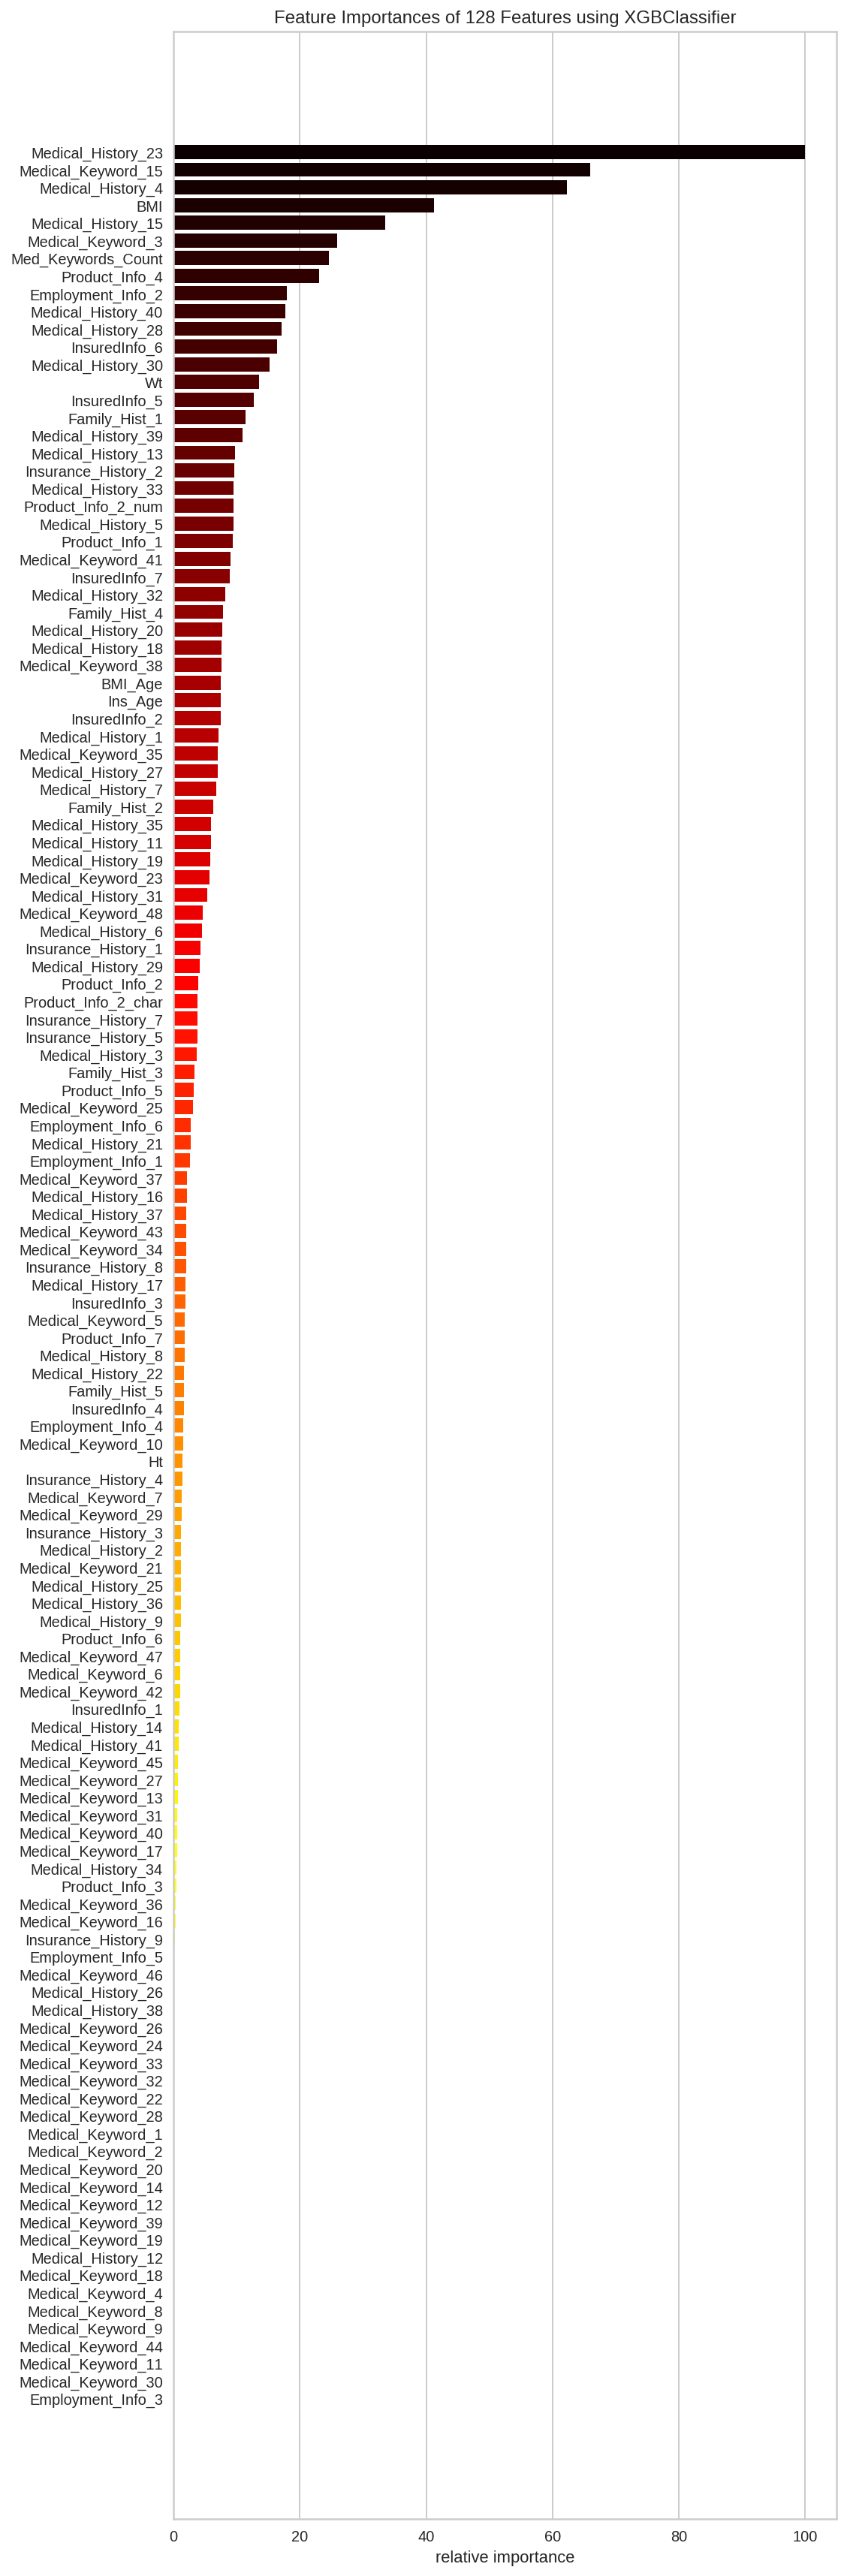

In [ ]:
plt.figure(figsize=(8,24))
viz = FeatureImportances(clf_xgb,colormap='hot_r')
viz.fit(df_Xtrain, ytrain)
viz.show()

# Model Evaluation: using eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

## eli5: Permutation Importance show weights

In [ ]:
perm = PermutationImportance(clf_xgb).fit(df_Xtest, ser_ytest)

In [ ]:
eli5.show_weights(perm, feature_names = df_Xtrain.columns.tolist(), top=50)

## eli5: explain weights

In [ ]:
eli5.explain_weights_df(perm, feature_names=features_train)\
  .head(10).style.background_gradient(subset=['weight'])

## eli5: show prediction

In [ ]:
eli5.show_prediction(clf_xgb, df_Xtest.iloc[0,:],show_feature_values=True)

# Model Evaluation: using PDP

- https://github.com/SauceCat/PDPbox/blob/master/tutorials/pdpbox_multiclass_classification.ipynb

```python
pdp.pdp_isolate(model, dataset, model_features,
feature, num_grid_points=10, 
grid_type='percentile', percentile_range=None,
grid_range=None, cust_grid_points=None, 
memory_limit=0.5, n_jobs=1, predict_kwds=None, 
data_transformer=None)

make sure n_jobs=1 when you are using XGBoost model.
```

In [ ]:
import pdpbox
from pdpbox import pdp
from pdpbox import info_plots

pdpbox.__version__

'0.2.0'

In [ ]:
feature = 'BMI'

## PDP: pdp isolate
```python
pdp.pdp_isolate(model, dataset, model_features,
feature, num_grid_points=10,
grid_type='percentile', percentile_range=None, 
grid_range=None, cust_grid_points=None, 
memory_limit=0.5, n_jobs=1, predict_kwds=None,
data_transformer=None)
```

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

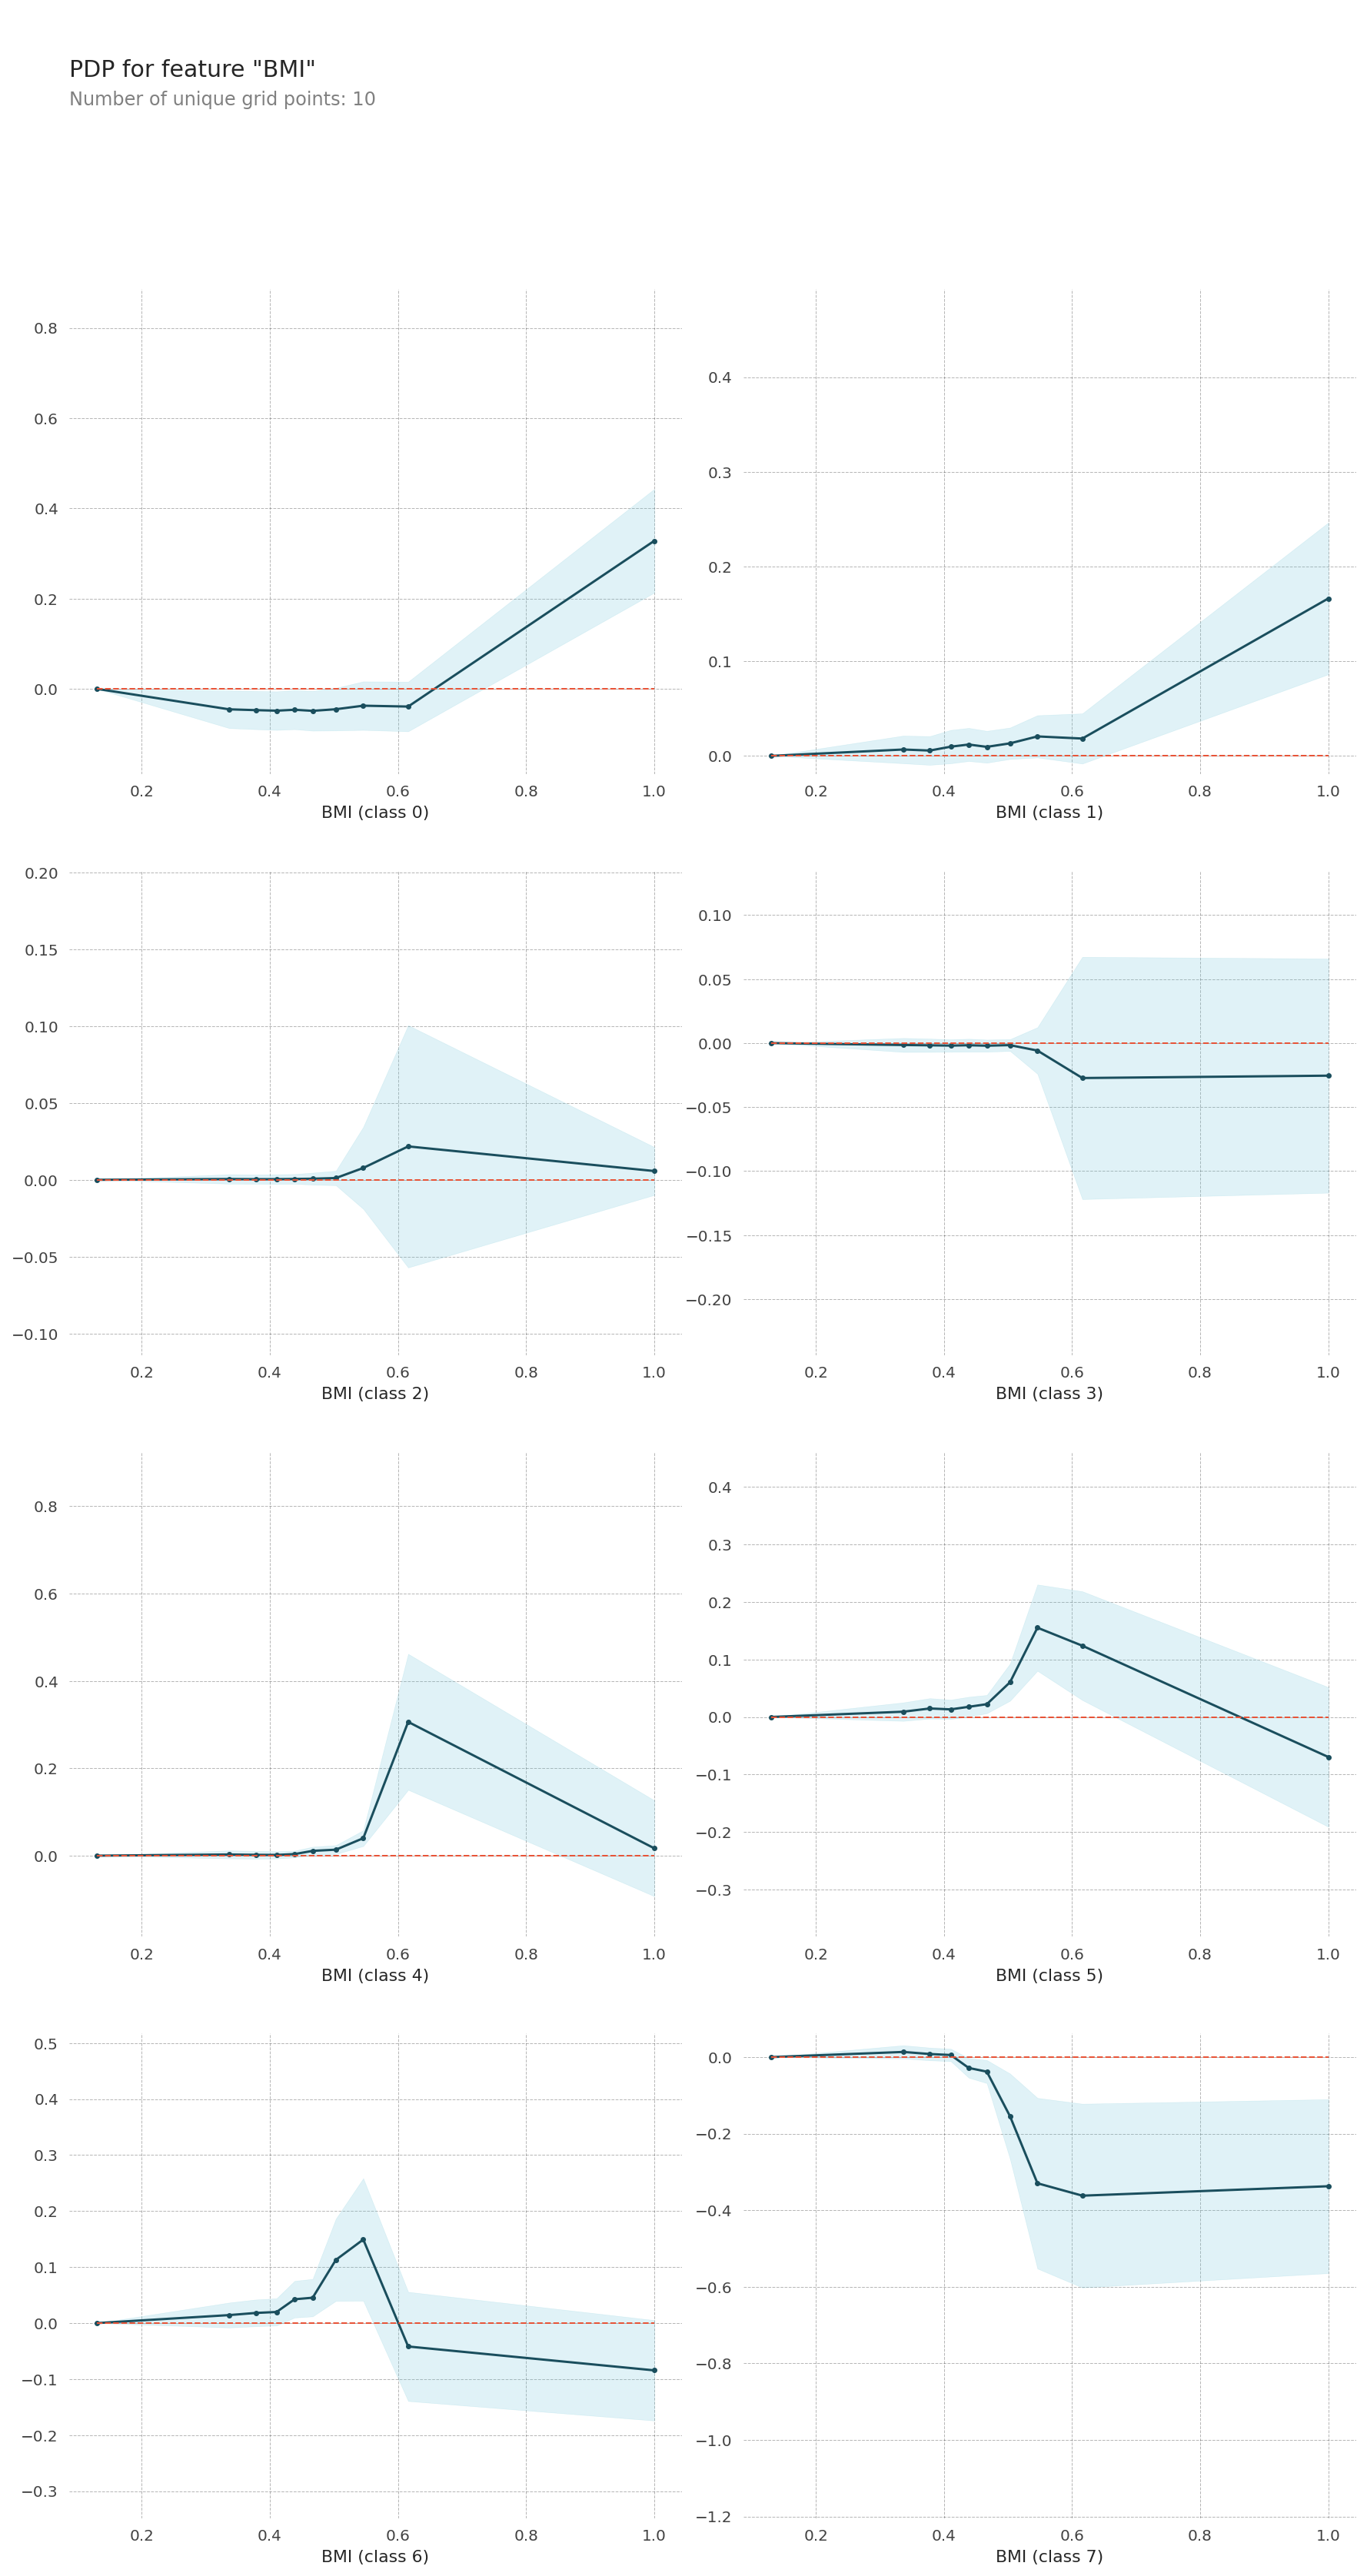

In [ ]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=clf_xgb,
                dataset=df_Xtest,
                model_features=df_Xtest.columns.tolist(),
                feature=feature,
                n_jobs=1) # make sure n_jobs=1 when you are using XGBoost model.

# plot it
pdp.pdp_plot(pdp_goals, feature)
plt.show()

In [ ]:
"""
Assume Respons8 means policy accepted.

Look at class 7 (Response8)

The bmi line is below the red dotted line ==> higher bmi lower chance of policy being granted

0 to 0.4   ==> bmi increse has not much effect
0.4 to 0.6 ==> higher bmi higher rejection
0.6+       ==> the value saturates.

""";

In [ ]:
np.unique(df[target])

array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
"""
Our target names are 1-8, but default pdp-box class names are 0-7.

""";

In [ ]:
df_target_encoded = pd.get_dummies(df,columns=[target],drop_first=False)
df_target_encoded.iloc[:2,-10:]

BMI_Age  Med_Keywords_Count  Response_1  ...  Response_6  Response_7  Response_8
0  0.207304                   0           0  ...           0           0           1
1  0.016256                   0           0  ...           0           0           0

[2 rows x 10 columns]

In [ ]:
features_train = df.columns.drop(target)
features_train

Index(['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4',
       'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht',
       'Wt',
       ...
       'Medical_Keyword_43', 'Medical_Keyword_44', 'Medical_Keyword_45',
       'Medical_Keyword_46', 'Medical_Keyword_47', 'Medical_Keyword_48',
       'Product_Info_2_char', 'Product_Info_2_num', 'BMI_Age',
       'Med_Keywords_Count'],
      dtype='object', length=128)

In [ ]:
target_cols = [f'Response_{i}' for i in range(1,9)]
target_cols

['Response_1',
 'Response_2',
 'Response_3',
 'Response_4',
 'Response_5',
 'Response_6',
 'Response_7',
 'Response_8']

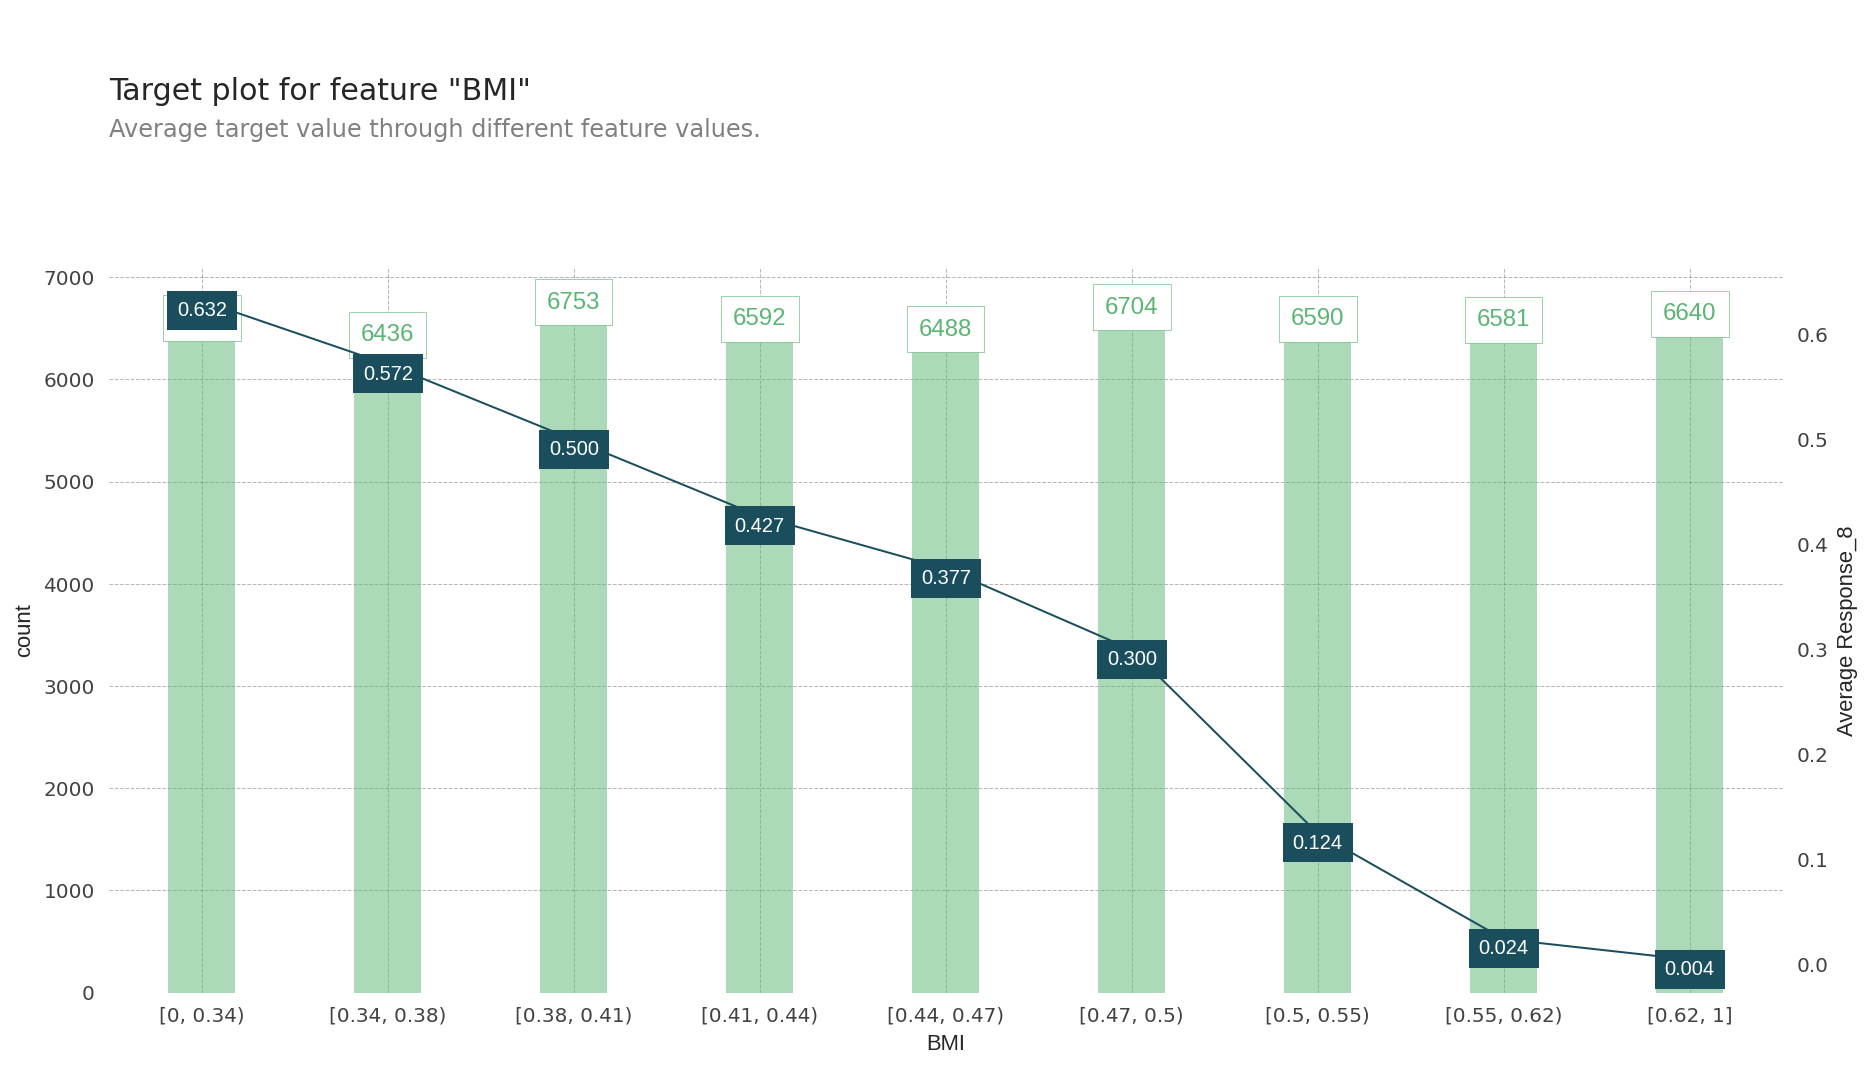

In [ ]:
fig, axes, summary_df = info_plots.target_plot(
    df=df_target_encoded,
    feature=feature,
    feature_name=feature, 
    target=['Response_8']
)

# we can see when bmi increases, then average response8 decreases.
# high bmi ==> low response8 ==> low acceptance.

In [ ]:
summary_df

x display_column  value_lower  value_upper  count  Response_8
0  0      [0, 0.34)     0.000000     0.336002   6597    0.632257
1  1   [0.34, 0.38)     0.336002     0.376807   6436    0.571628
2  2   [0.38, 0.41)     0.376807     0.410593   6753    0.499630
3  3   [0.41, 0.44)     0.410593     0.438952   6592    0.426729
4  4   [0.44, 0.47)     0.438952     0.466858   6488    0.376695
5  5    [0.47, 0.5)     0.466858     0.501185   6704    0.299523
6  6    [0.5, 0.55)     0.501185     0.545946   6590    0.124279
7  7   [0.55, 0.62)     0.545946     0.619419   6581    0.023553
8  8      [0.62, 1]     0.619419     1.000000   6640    0.003916

## check prediction distribution

```python
info_plots.actual_plot(model, X, feature,
feature_name, num_grid_points=10,
grid_type='percentile', percentile_range=None,
grid_range=None, cust_grid_points=None,
show_percentile=False, show_outliers=False,
endpoint=True, which_classes=None,
predict_kwds=None, ncols=2, figsize=None, 
plot_params=None)

Parameters
----------

model: a fitted sklearn model
X: pandas DataFrame
    data set on which the model is trained
which_classes: list, optional, default=None
    which classes to plot, only use when it is a multi-class problem
```

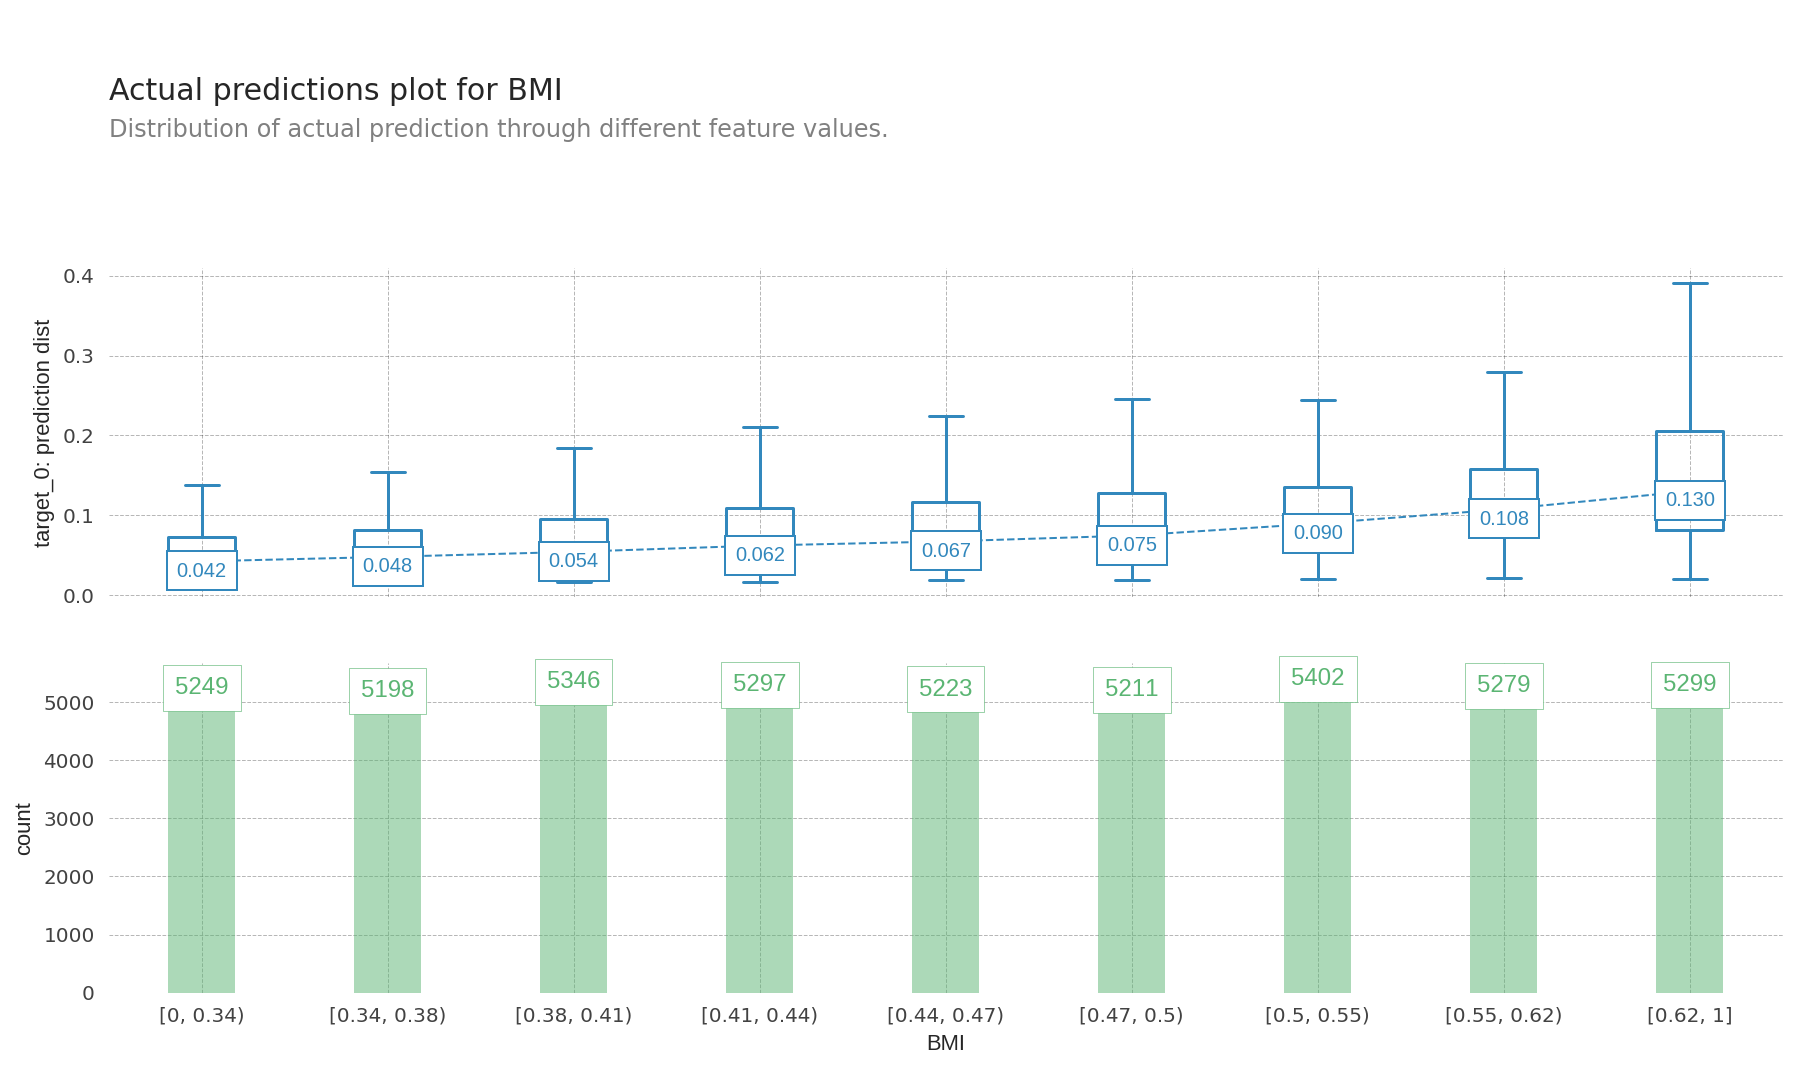

In [ ]:
fig, axes, summary_df = info_plots.actual_plot(
    model=clf_xgb, 
    X=df_Xtrain, 
    feature=feature, 
    feature_name=feature, 
    which_classes=[0],
    predict_kwds={},
)

## partial dependence plot (pdp)

In [ ]:
%%time 
pdp_bmi_xgboost = pdp.pdp_isolate(
    model=clf_xgb,
    dataset=df_target_encoded, 
    model_features=features_train, 
    feature=feature
)

CPU times: user 30.6 s, sys: 126 ms, total: 30.7 s
Wall time: 16.4 s


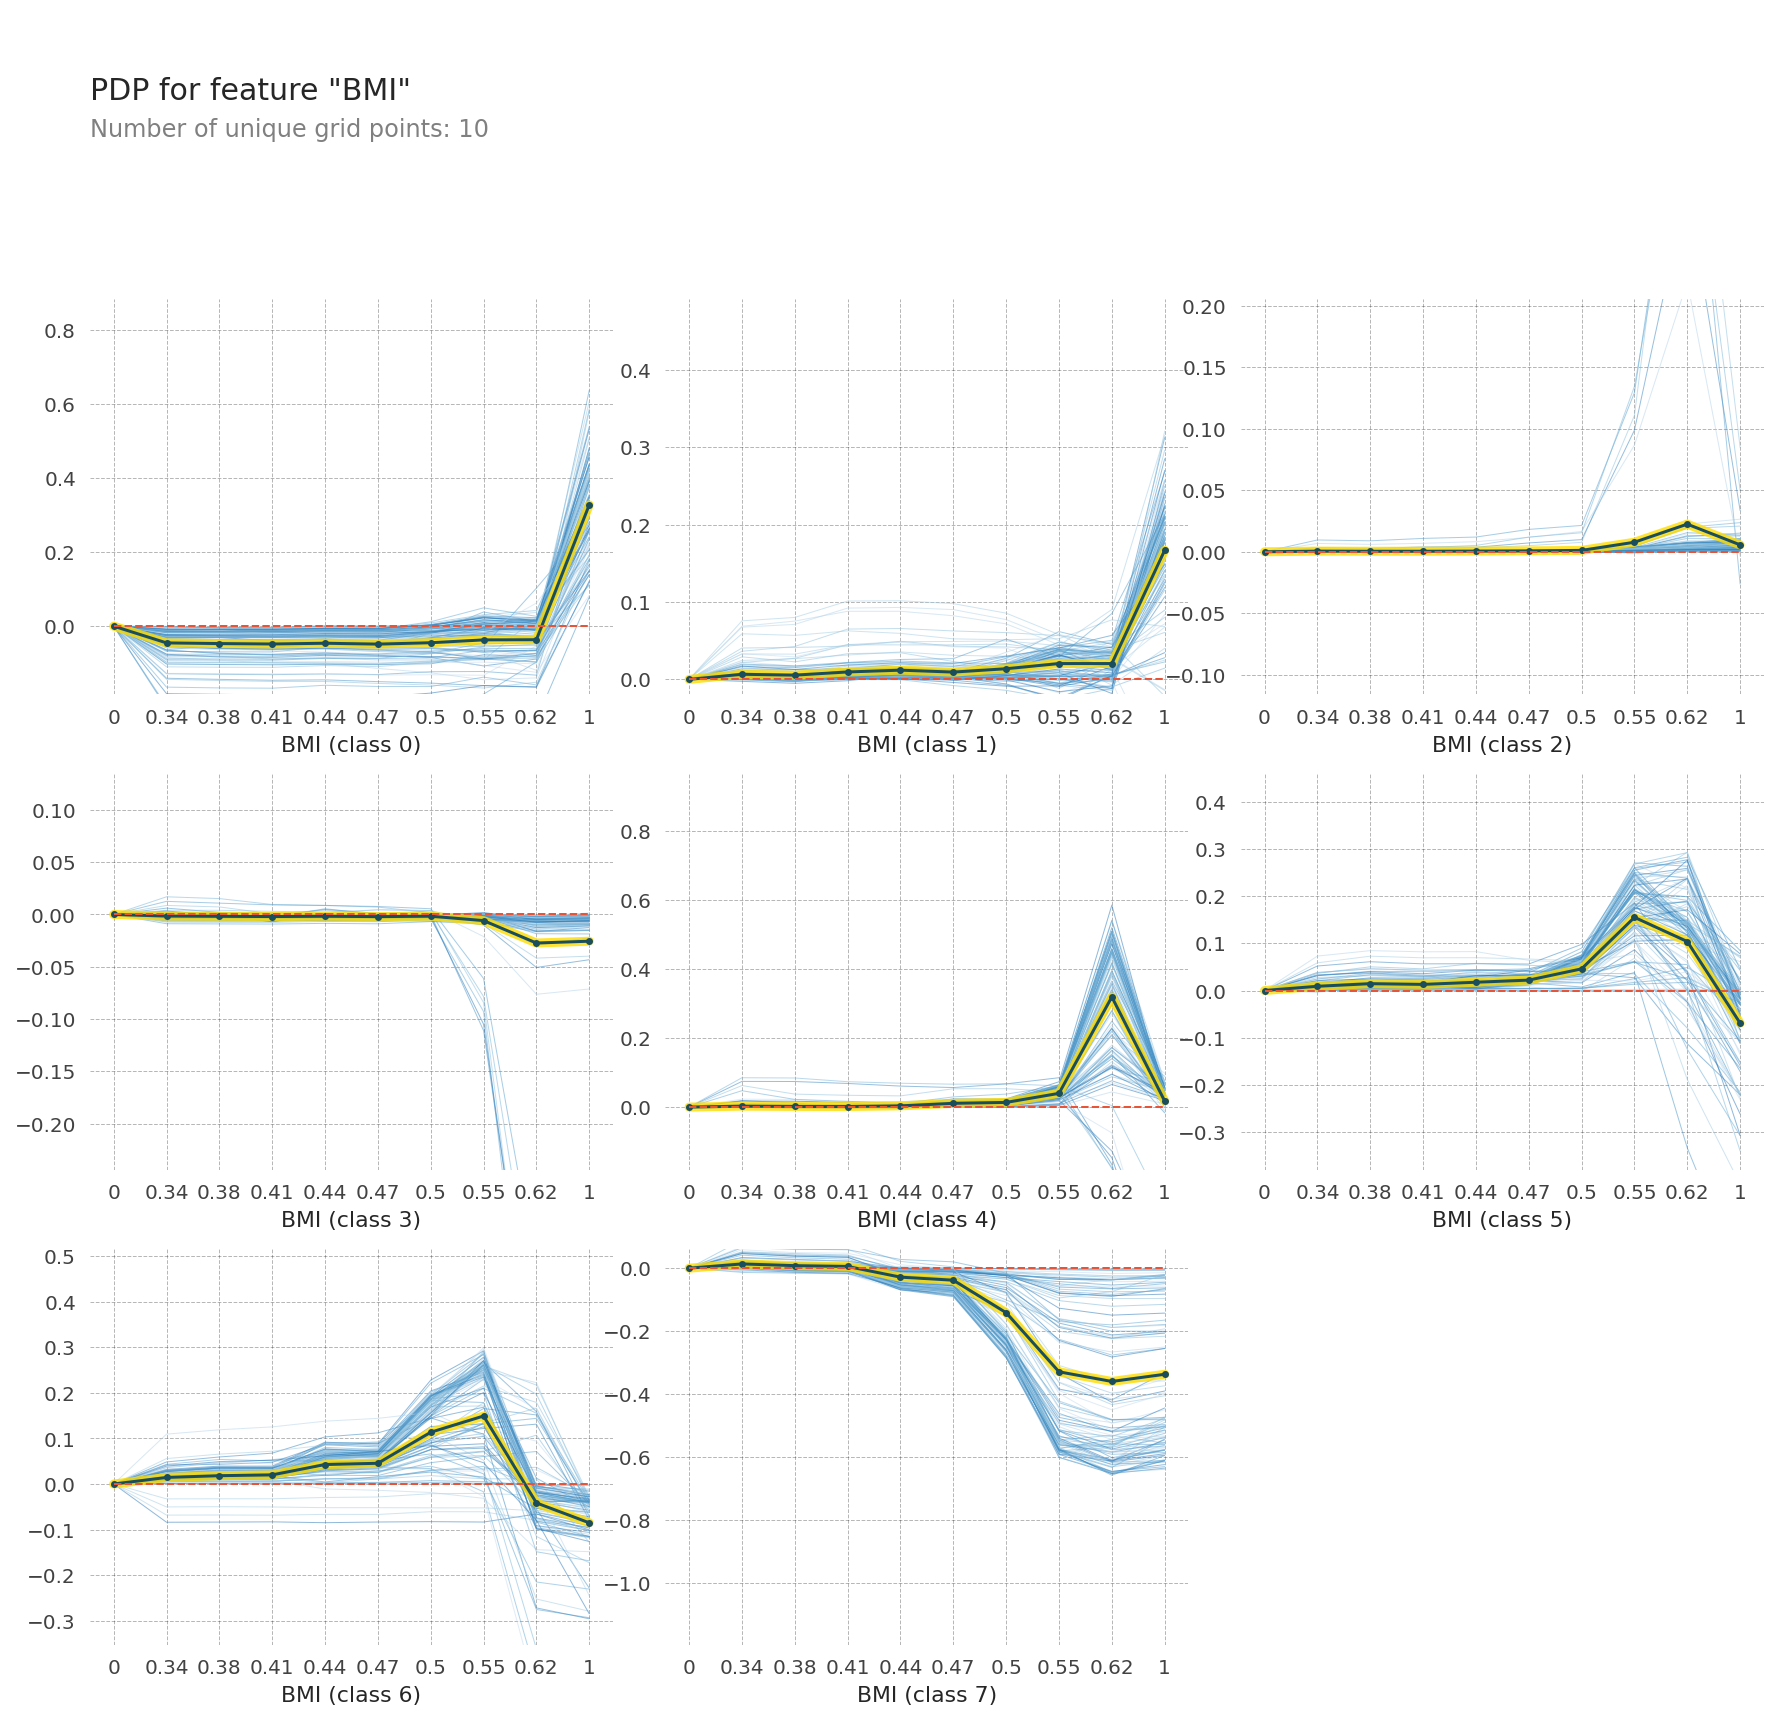

In [ ]:
fig, axes = pdp.pdp_plot(
    pdp_isolate_out=pdp_bmi_xgboost, 
    feature_name=feature, 
    center=True, 
    x_quantile=True, 
    ncols=3, 
    plot_lines=True, 
    frac_to_plot=100
)

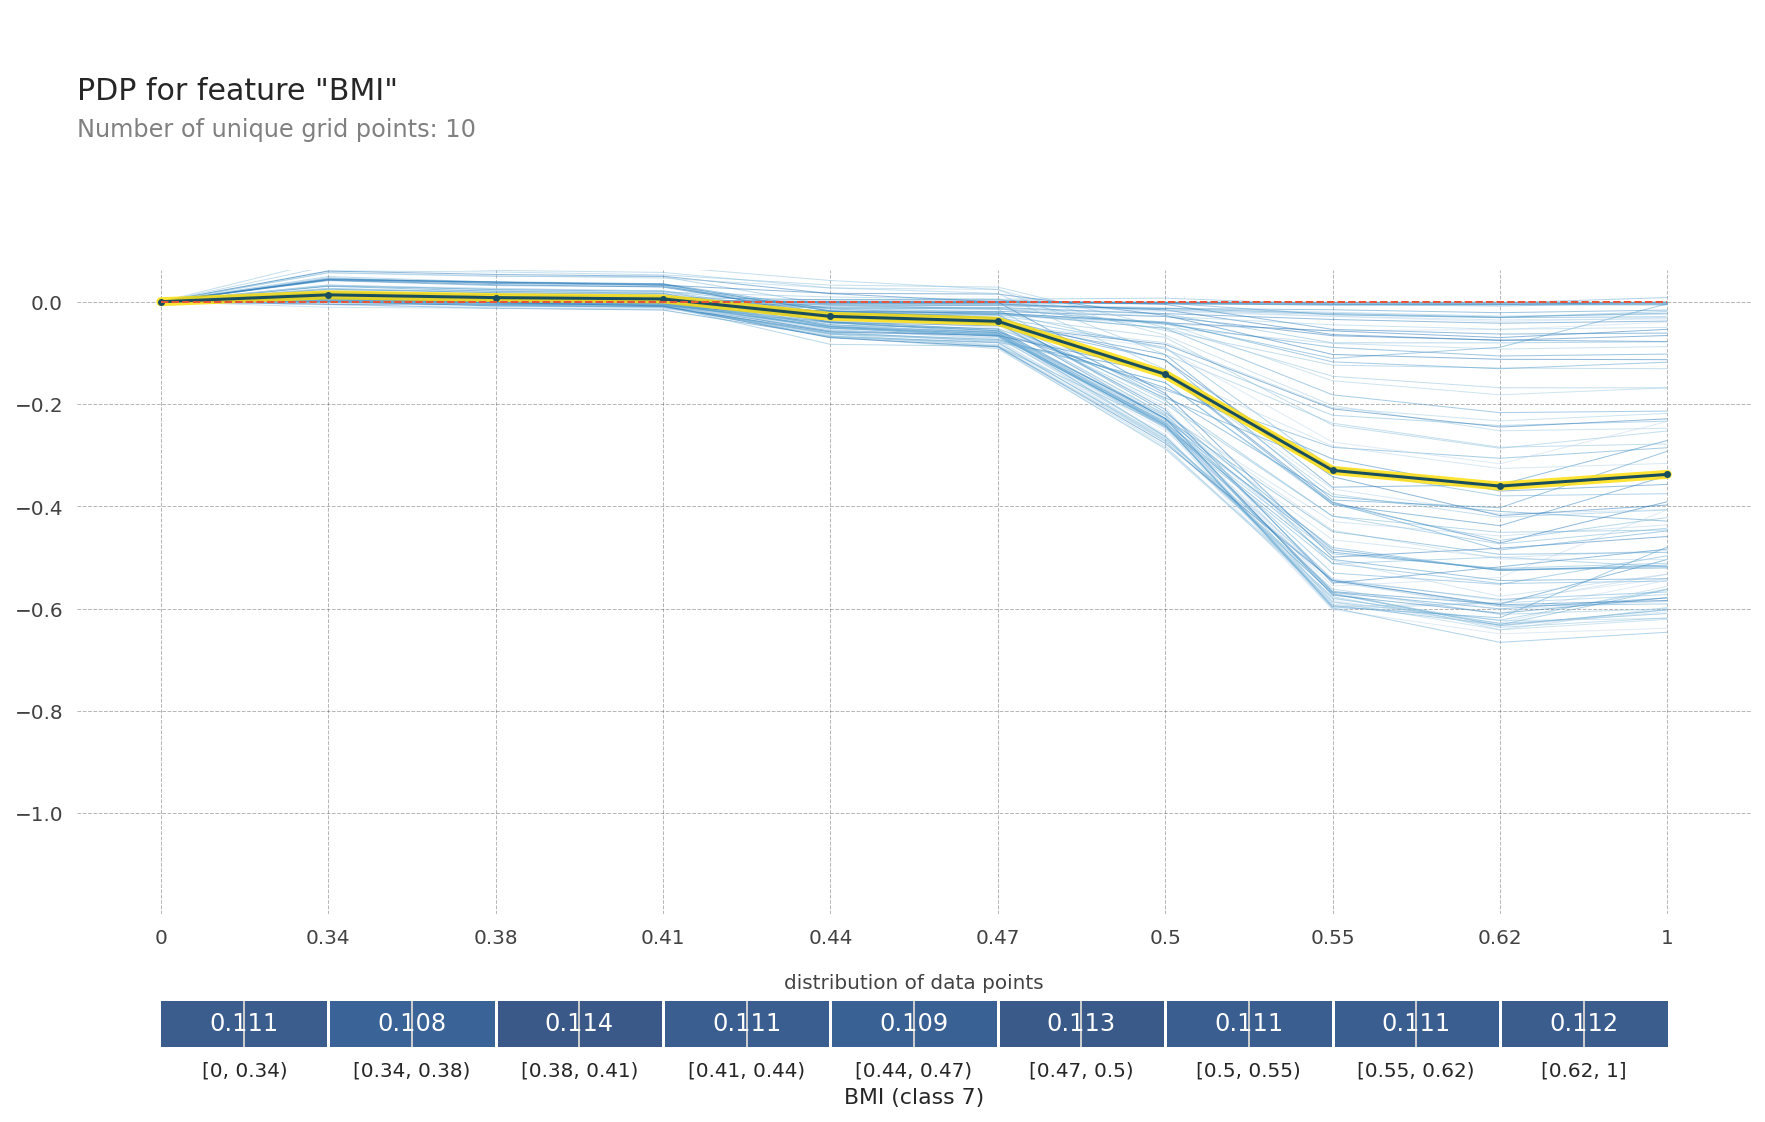

In [ ]:
fig, axes = pdp.pdp_plot(
    pdp_bmi_xgboost, 
    feature, 
    center=True, 
    x_quantile=True, 
    ncols=1, 
    plot_lines=True, 
    frac_to_plot=100,
    which_classes=[7], 
    plot_pts_dist=True
)

In [ ]:
"""
Important Observation:

- All the bmi bins have sufficient persons. Certain range of bmi is NOT missing.
- bmi curve is below the red dotted line ==> negative impact with prediction
- bmi increase upto 0.44 has almost no impact.
- bmi increase 0.44 - 0.55 ==> less policy accepted
- bmi increase 0.55+       ==> saturates and still less policy accepted.

""";

## Interaction between two variables: bmi and Medical_History_4 with Target

In [ ]:
df.iloc[:2,-10:]

Medical_Keyword_44  Medical_Keyword_45  ...   BMI_Age  Med_Keywords_Count
0                   0                   0  ...  0.207304                   0
1                   0                   0  ...  0.016256                   0

[2 rows x 10 columns]

In [ ]:
two_features = ['BMI', 'Medical_History_4']

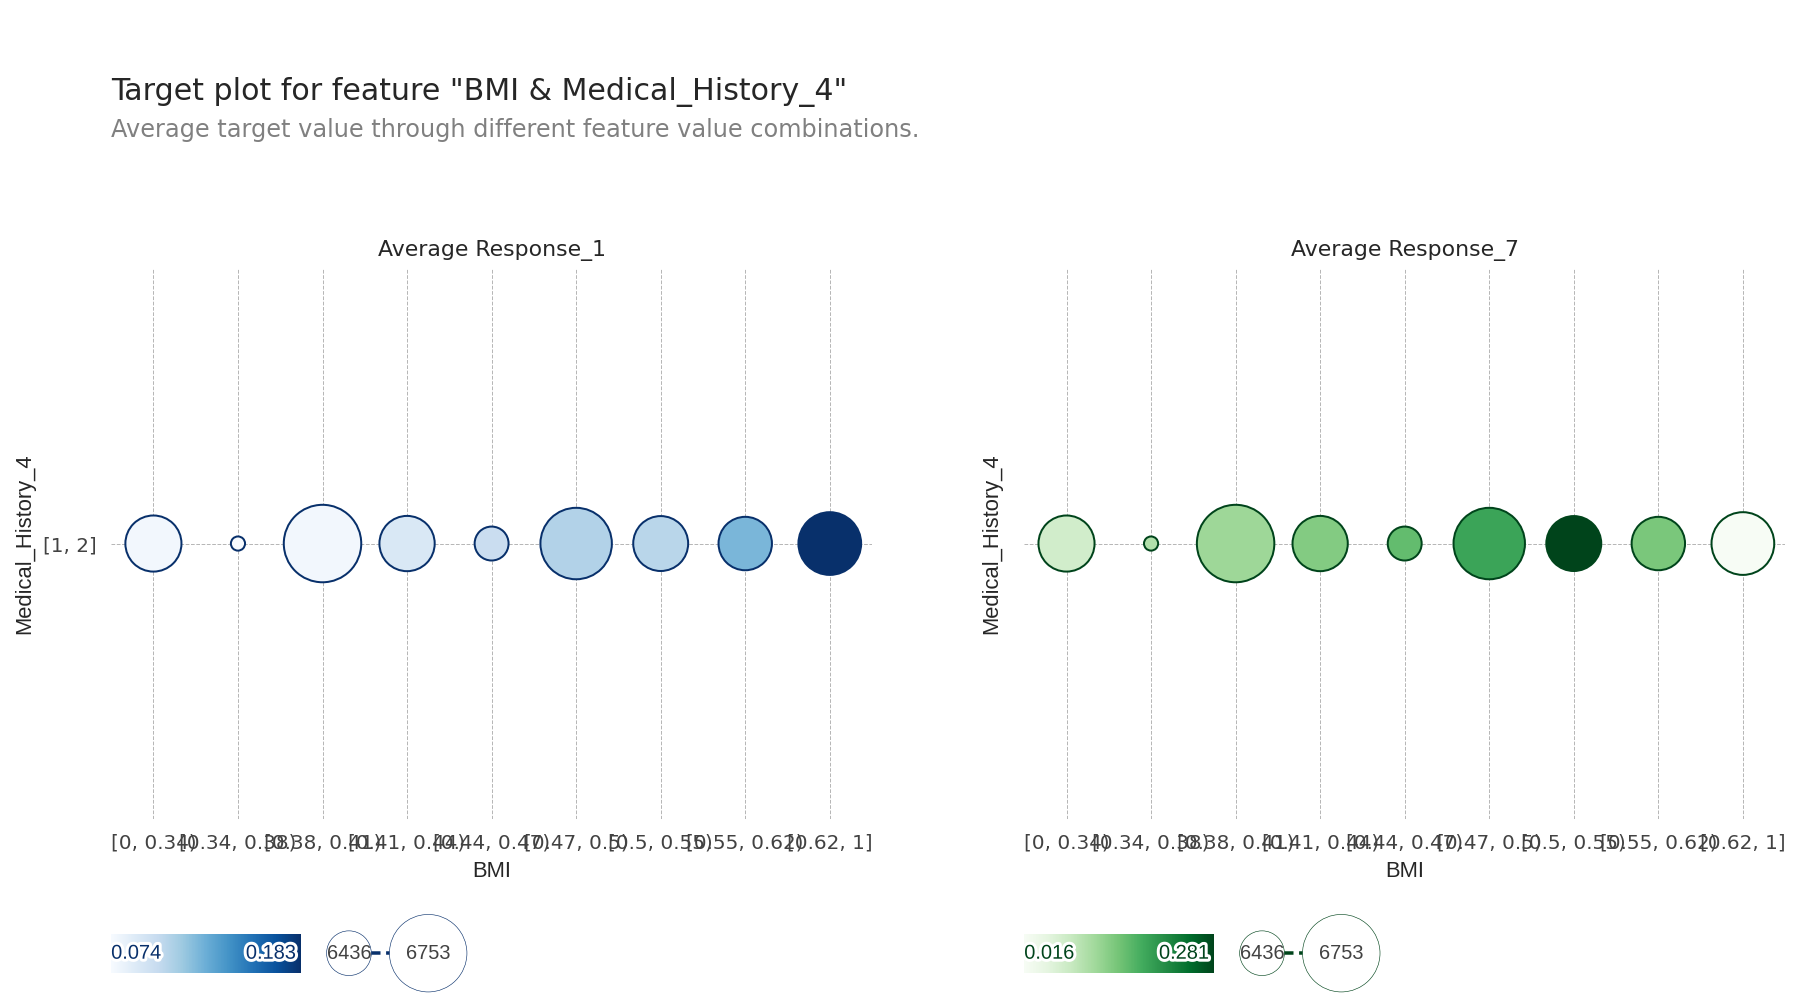

In [ ]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df_target_encoded, 
    features=, 
    feature_names=two_features, 
    target=two_features
)

## prediction distribution through feature combination of 'BMI' and 'Medical_History_4'

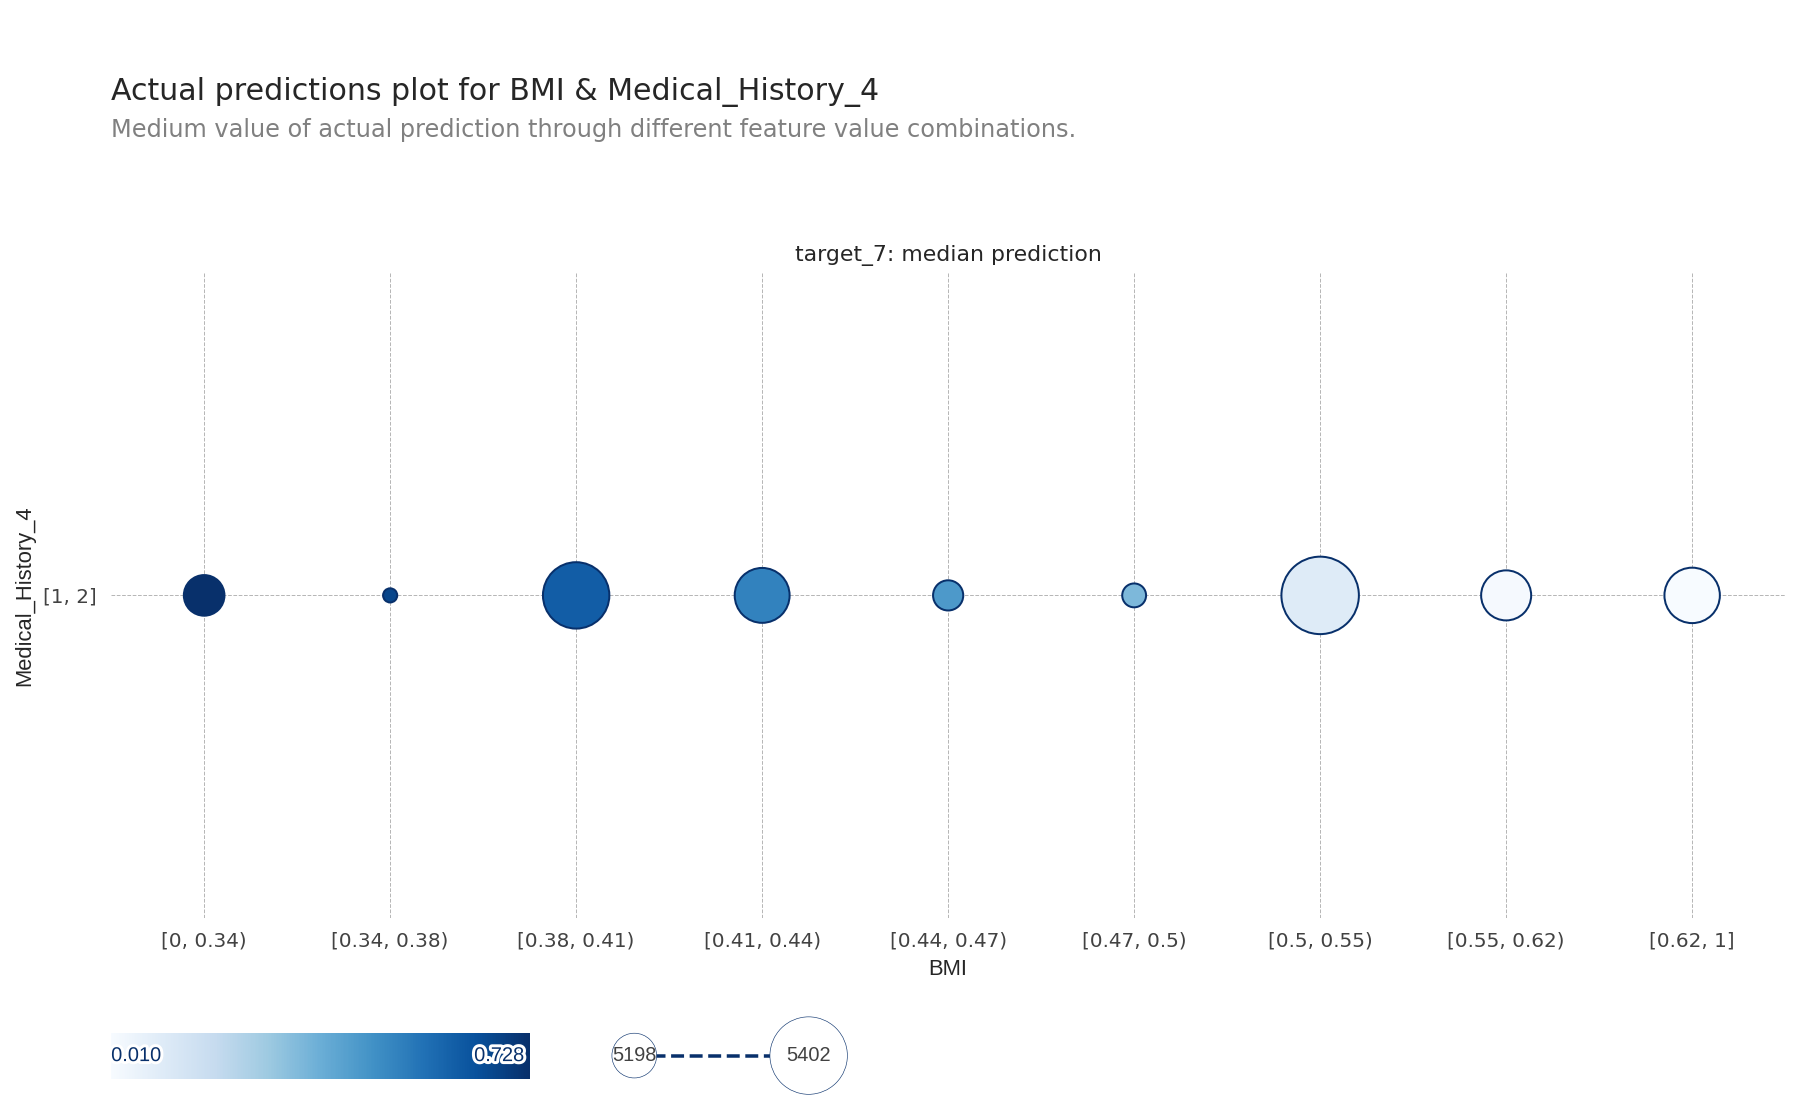

In [ ]:
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=clf_xgb, 
    X=df_Xtrain, 
    features=two_features, 
    feature_names=two_features,
    ncols=1,
    which_classes=[7]
)

# Model Evaluation: plots using SHAP

- https://github.com/slundberg/shap
- https://matplotlib.org/examples/color/colormaps_reference.html

SHAP = SHapley Additive exPlanations

In [ ]:
import shap
shap.__version__

'0.35.0'

## Get SHAP Values

In [ ]:
explainer = shap.TreeExplainer(clf_xgb)
shap_values = explainer.shap_values(df_Xtest)

In [ ]:
type(shap_values), type(explainer.expected_value), type(shap_values[0])

(list, list, numpy.ndarray)

In [ ]:
np.array(shap_values).shape

(8, 11877, 128)

In [ ]:
 np.array(explainer.expected_value).shape

(8,)

In [ ]:
df_Xtest.shape

(11877, 128)

## SHAP: Summary Plot

In [ ]:
cmap = plt.get_cmap("tab10")
colors = cmap.colors # tuple of tuples
# colors = sns.color_palette('husl',8)
# colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)] # etc

# get class ordering from shap values
class_inds = np.argsort([-np.abs(shap_values[i]).mean() for i in range(len(shap_values))])

# create listed colormap
from matplotlib import colors as plt_colors
cmap = plt_colors.ListedColormap(np.array(colors)[class_inds])

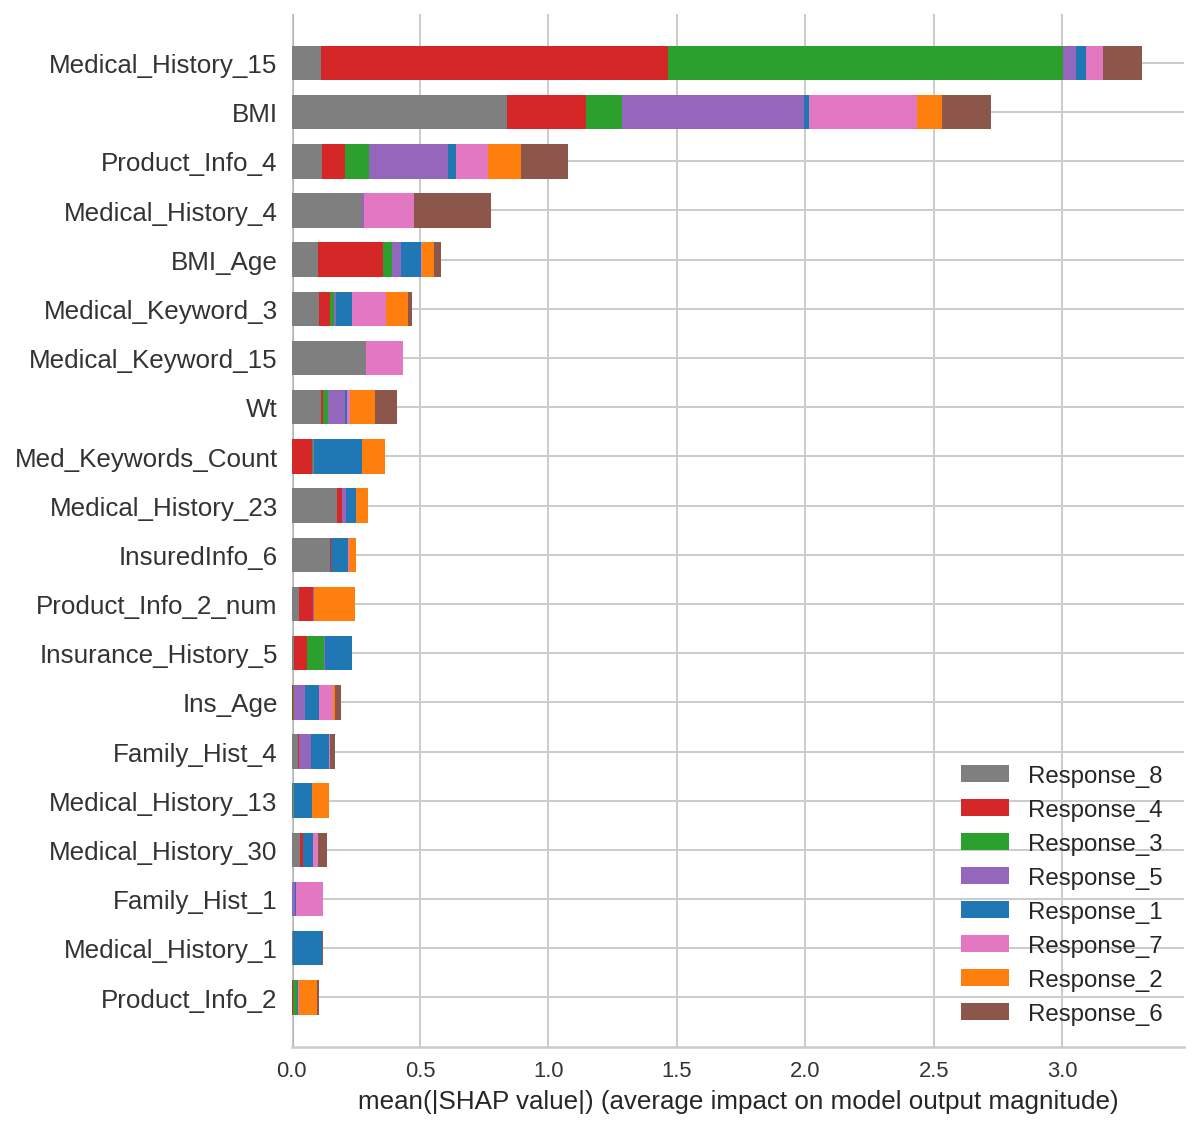

In [ ]:
shap.summary_plot(shap_values, df_Xtest,
        class_names = [f'Response_{i+1}' for i in range(8)],
        color=cmap,
        plot_type="bar")

                                        SHAP plot for Response 8


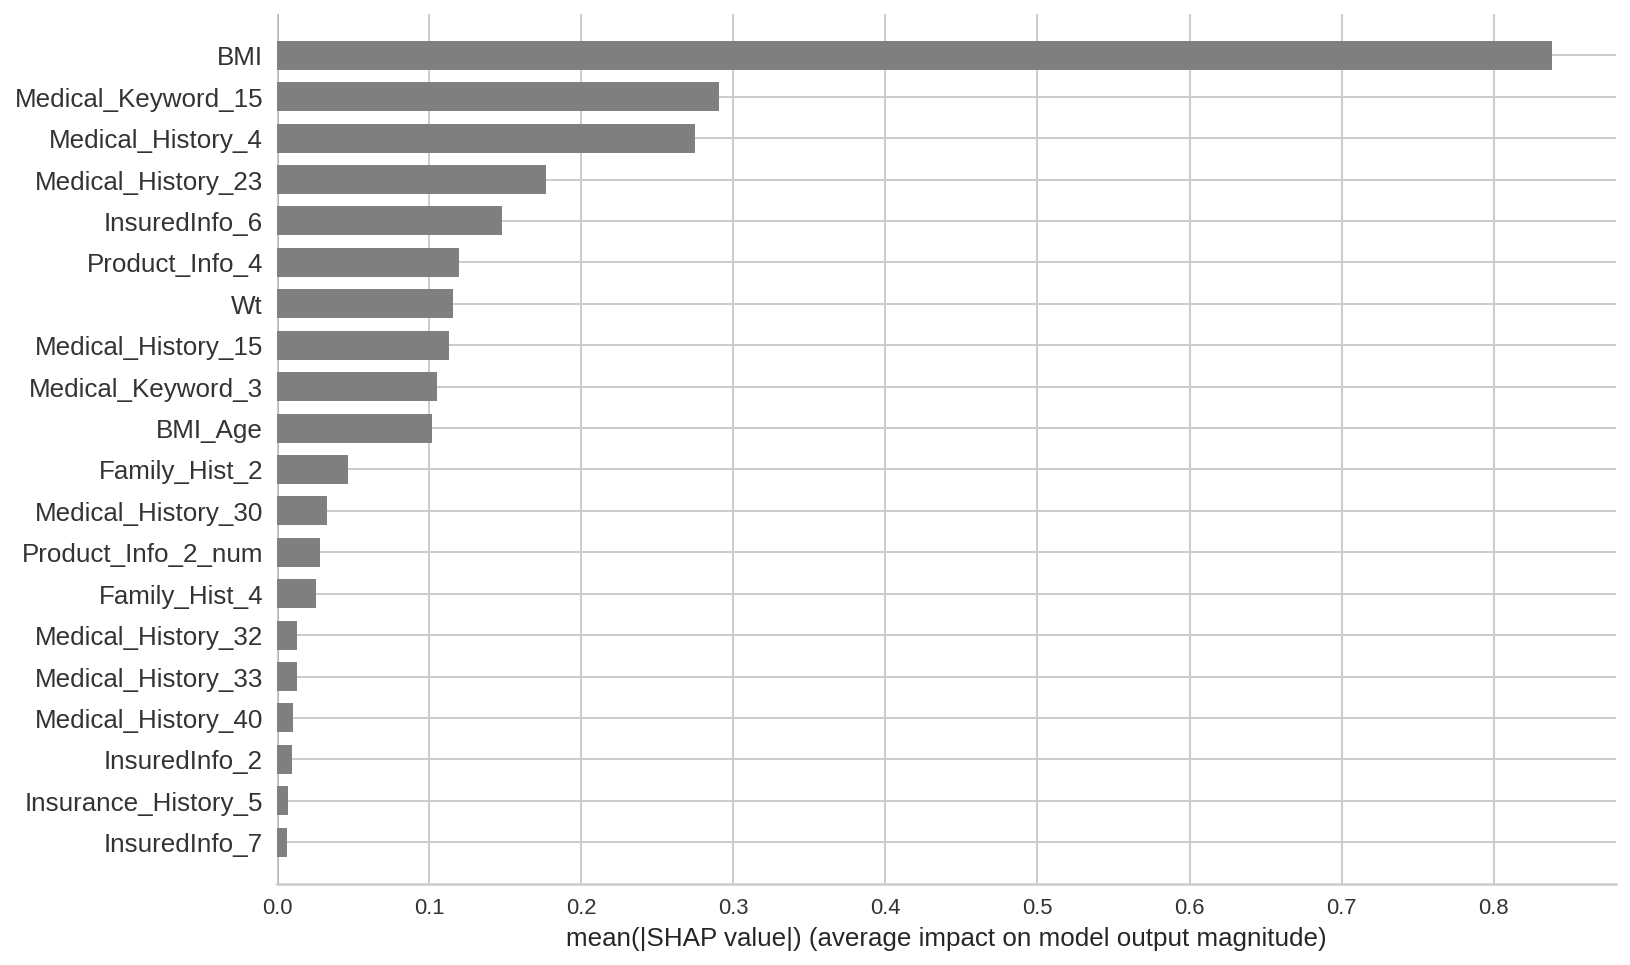

In [ ]:
targetNum = 7
title = "  "*20 + f"SHAP plot for Response {targetNum+1}"
print(title)
shap.summary_plot(shap_values[targetNum], df_Xtest,
        title = title, # title dont work.
        class_names = [f'Response_{targetNum+1}'],
        color=colors[targetNum], # NOTE: colors[0] not colors[1] for Response_1
        plot_type="bar",
        plot_size = (12,8)
        )

"""
Note: By default the colors in multiclass shap summary plot
are determined by mean of shap values.

They are NOT in the same order given in cmap.colors.

""";

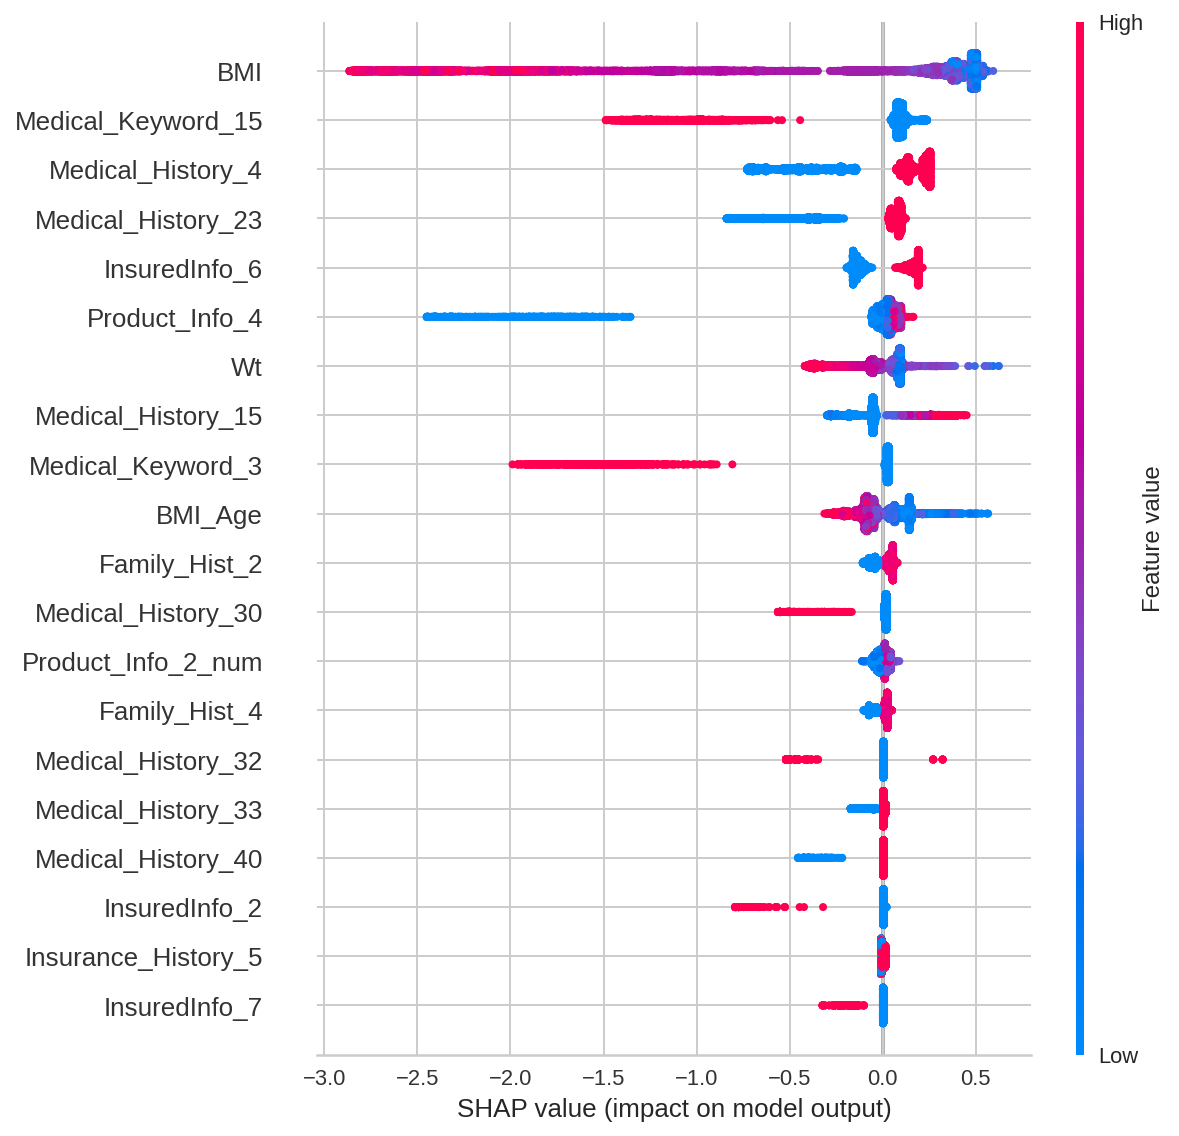

In [ ]:
shap.summary_plot(shap_values[targetNum], df_Xtest)

In [ ]:
"""
Important Observations:

Lets assume that response_8 is the policy grant and other response(1-7) are reject.

1. Features are sorted in descending order of its importance.
2. BMI has High (red in colour) and negative (less than 0) effect on the target.
   This means higher the BMI, higher the rejection.
3. Conversely, Med Hist 4 has High (red) and positive (greater than 0)
   effect on the target. 
   This means that the higher the value of Med Hist 4, 
   the chances are higher for policy getting accepted.

""";

## SHAP: Force Plot
- https://christophm.github.io/interpretable-ml-book/shap.html

In [ ]:
# shap.force_plot(explainer.expected_value[0],
#                 shap_values[0],
#                 matplotlib=False,
#                 text_rotation=90)

# this is too slow, we can use only first 1000 rows.

In [ ]:
shap_values[0].shape

(11877, 128)

In [ ]:
x = shap_values[0][:100,:]
x.shape

(100, 128)

In [ ]:
explainer.expected_value[7]

1.5381206

In [ ]:
# target = Response_1
# row = only first few rows
targetNum = 7 # 7 is Response_8
shap.initjs()
shap.force_plot(explainer.expected_value[targetNum],
                shap_values[targetNum][:100,:], # take only first N rows
                feature_names = features_train,
                matplotlib=False,
                text_rotation=90)

Average shap for the group: 1.5381206274032593


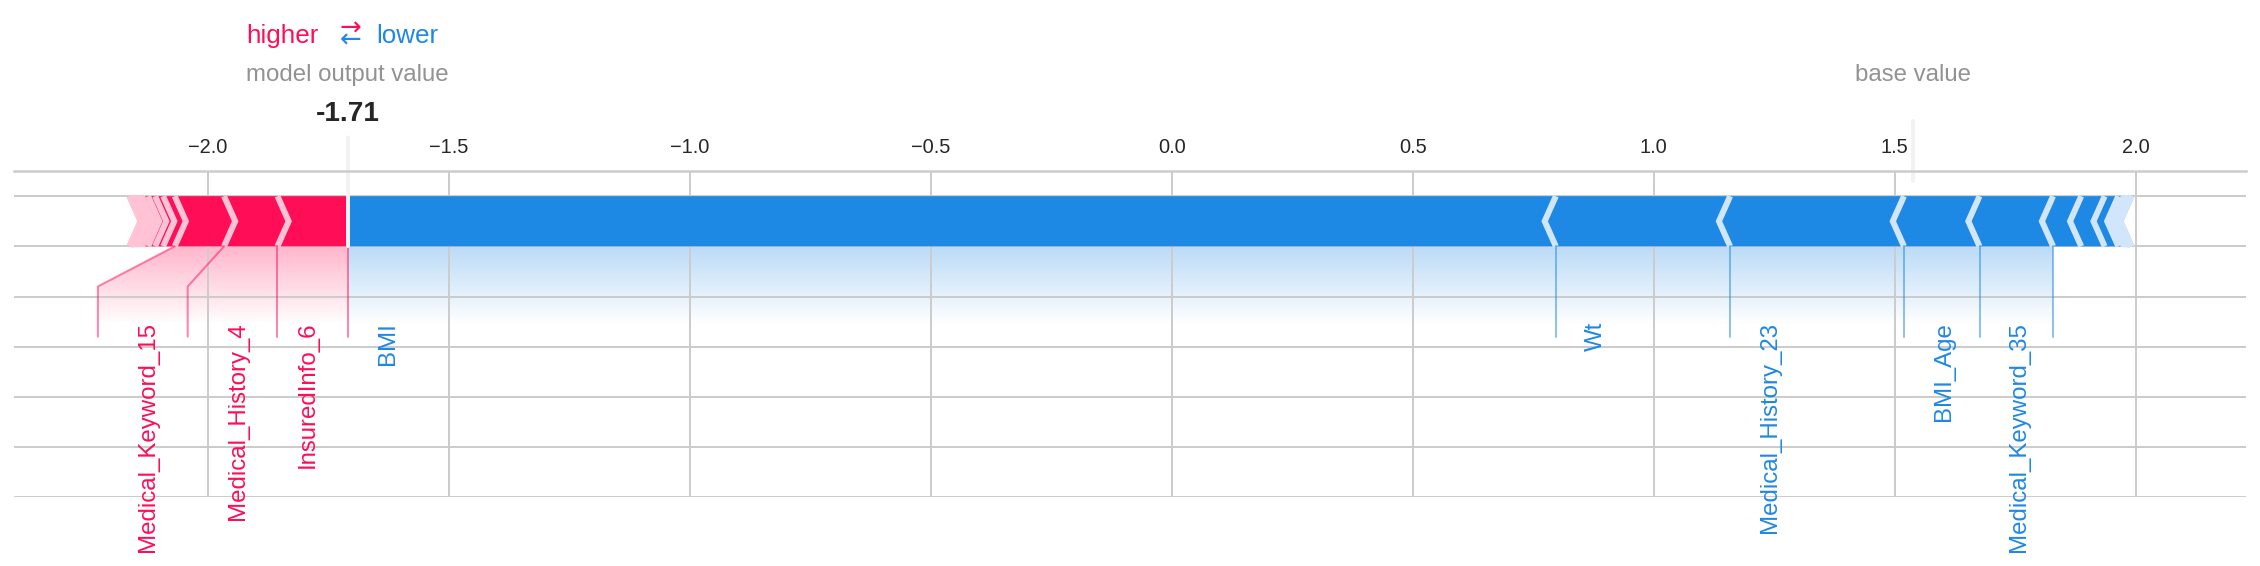

In [ ]:
# target = Response_1
# row = only one row (only one customer)
shap.initjs()
rowNum = 0
targetNum = 7 # 7 is Response_8

print(f'Average shap for the group: {explainer.expected_value[targetNum]}')

shap.force_plot(explainer.expected_value[targetNum],
                shap_values[targetNum][rowNum,:],
                feature_names = features_train,
                matplotlib=True,
                text_rotation=90 # only works when matplotlib=True
                )

In [ ]:
"""
We can visualize feature attributions such as Shapley values as "forces". 
Each feature value is a force that either increases or decreases the prediction.
The prediction starts from the baseline. 
The baseline for Shapley values is the average of all predictions. 
In the plot, each Shapley value is an arrow that pushes to increase 
(positive value) or decrease (negative value) the prediction.
These forces balance each other out at the actual prediction of the data instance.


The baseline -- the average predicted probability -- is 1.53.
The person has prediction =  -1.71 < baseline
The person's application likely NOT to be accepted.

MH = medical history
MK = medical keyword

From summary_plot:
higher is better:  MH_4_23_33_40
lower is better :  MH_30_32 MK_13_3 Insured_info_2_7 bmi wt bmi_wt

Although medical_history_23 is high for this particular person, the features
such as wt bmi_age are high and they offset the goodness of high
medical_history_23 and overall result is bad.

The persons application is not likely to be accepted.
""";


In [ ]:
df_ypreds.head(6)

ytest  ypreds  is_Response8
0      1       6             0
1      7       8             0
2      8       8             1
3      6       6             0
4      7       7             0
5      8       6             1

Average shap for the group: 1.5381206274032593


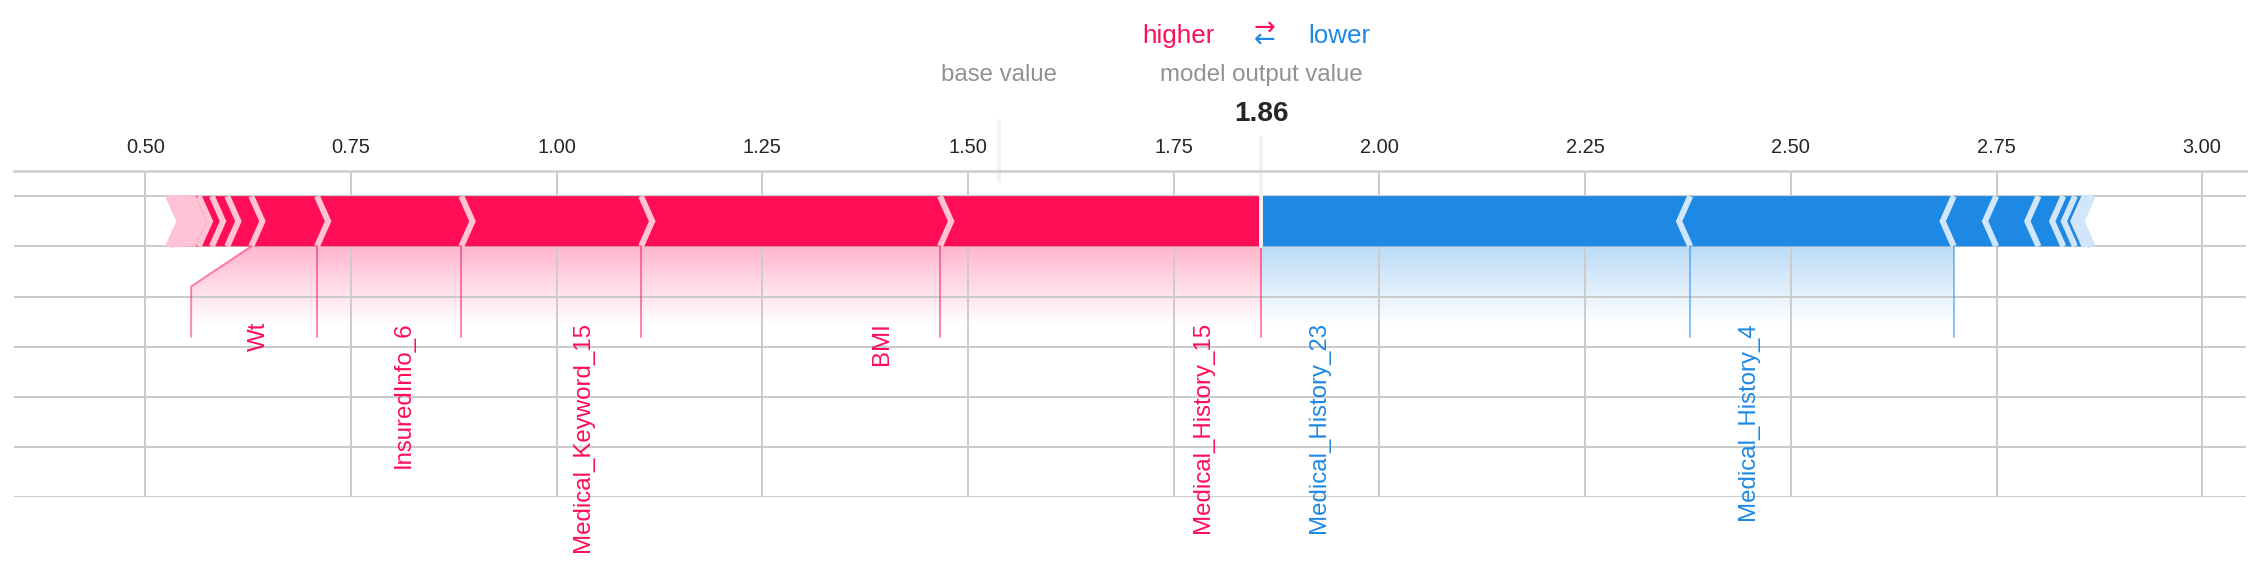

In [ ]:
# target = Response_1
# row = only one row (only one customer)
shap.initjs()
rowNum = 2
targetNum = 7 # 7 is Response_8

print(f'Average shap for the group: {explainer.expected_value[targetNum]}')

shap.force_plot(explainer.expected_value[targetNum],
                shap_values[targetNum][rowNum,:],
                feature_names = features_train,
                matplotlib=True,
                text_rotation=90 # only works when matplotlib=True
                )

In [ ]:
"""

The baseline -- the average predicted probability -- is 1.53.
The person has prediction =  1.86
which is much higher than the baseline 1.53.

MH = medical history
MK = medical keyword

From summary_plot:
higher is better:  MH_4_23_33_40
lower is better :  MH_30_32 MK_13_3 Insured_info_2_7 bmi wt bmi_wt

Effect is GOOD. The person's application likely to be accepted.

""";

## SHAP: Dependence Plot

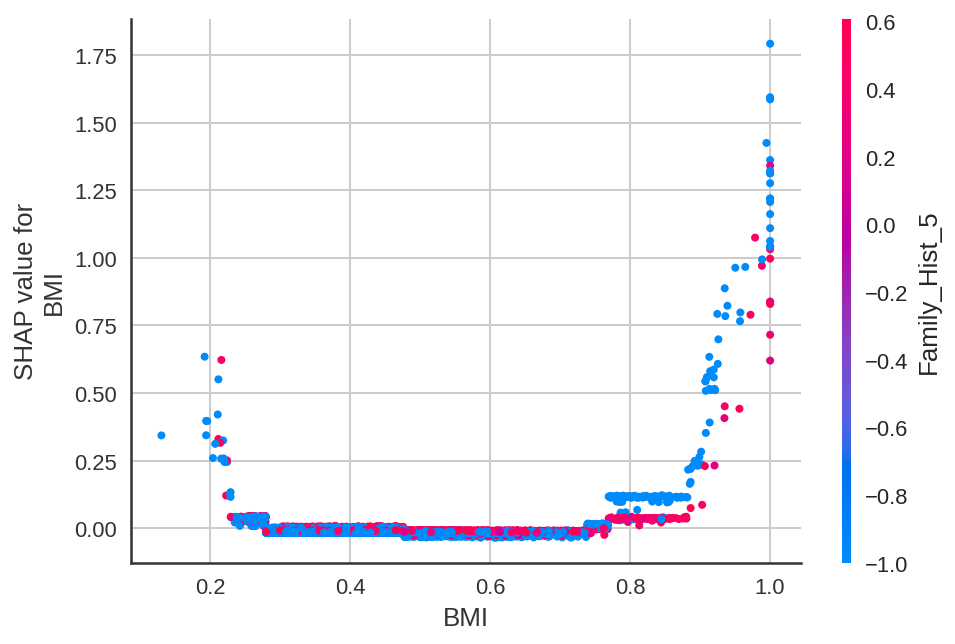

In [ ]:
shap.dependence_plot(feature, shap_values[0], df_Xtest)

In [ ]:
# features_train

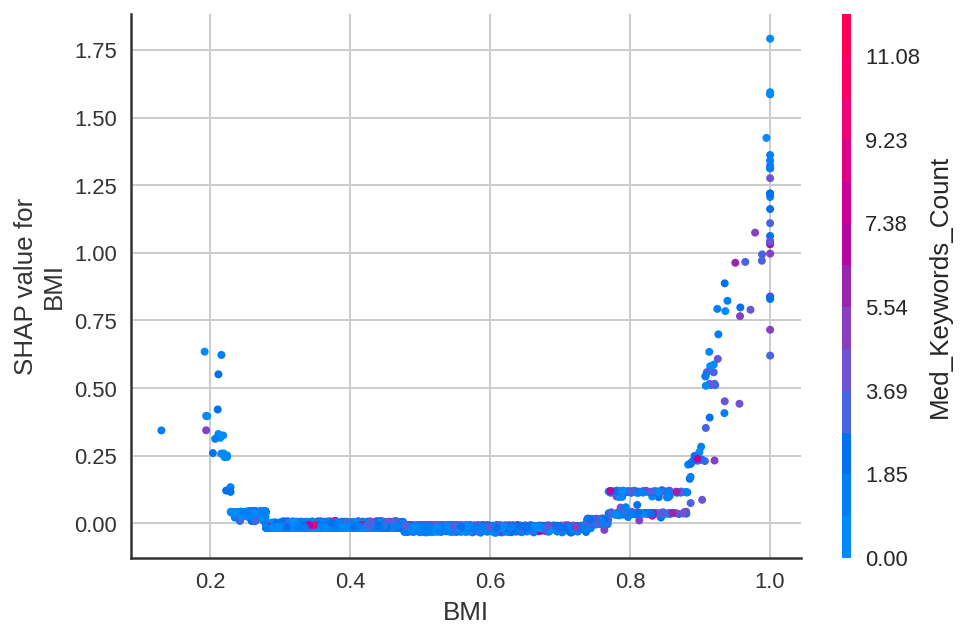

In [ ]:
shap.dependence_plot(feature, shap_values[0], df_Xtest,
                    interaction_index='Med_Keywords_Count')